1. Make sure that b-splines are correct
    x. Check the code for obvious errors
    2. Write energy function that works with b-splines
    3. Check if the TPF and B-spline energies are the same
2. Write LinReg optimization function
3. Fit energy to an existing potential (e.g., Marinica)
4. Write Backfitting optimization function
5. Optimize stat. distance

In [12]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product
from scipy.optimize import minimize

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core
from statmechlib.forcefields import f_embed, f_dens, f_spline3

In [15]:
working = '../data/working'

In [16]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [17]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi, encoding='latin1')

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi, encoding='latin1')

len 50


In [18]:
targets['eos']['box'] = targets['eos']['box'][5:6]
targets['eos']['xyz'] = targets['eos']['xyz'][5:6]
targets['eos']['temp'] = targets['eos']['temp'][5:6]
targets['eos']['beta'] = targets['eos']['beta'][5:6]
targets['eos']['energy'] = targets['eos']['energy'][5:6]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][5:6]

In [19]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][0:5]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][0:5]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][0:5]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][0:5]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][0:5]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][0:5]

In [20]:
# targets['eos_bcc']['box'] = targets['eos_bcc']['box'][1:4]
# targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][1:4]
# targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][1:4]
# targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][1:4]
# targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][1:4]
# stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][1:4]
# len(targets['eos_bcc']['energy']), len(stats_bspline['eos_bcc']['energy'])

In [21]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]

In [22]:
np.linspace(1.05, 4.25, 5)

array([1.05, 1.85, 2.65, 3.45, 4.25])

In [23]:
#edens_knots = list(np.linspace(1.05, 4.25, 5))
edens_knots = list(np.linspace(1.05, 4.25, 33))
#edens_knots = list(np.linspace(1.05, 5.25, 43))
pair_knots = list(np.linspace(1.05, 5.25, 43))

print(edens_knots)
print(pair_knots)

stats_list = [downselect(stats_bspline, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [24]:
def Dbs(n, order, lo_bound=[], hi_bound=[]):
    """B-spline penalty matrix
    """
    
    pen = {0:[1.0],
           1:[1.0, -1.0],
           2:[1.0, -2.0, 1.0],
           3:[1.0, -3.0, 3.0, -1.0],
           4:[1.0, -4.0, 6.0, -4.0, 1.0]}   
    
    n_lo = len(lo_bound)
    n_hi = len(hi_bound)
    n_tot = n + n_lo + n_hi

    # Extended penalty matrix
    P = np.zeros((n_tot, n_tot), dtype=float)
    
    for i in range(n_tot-order):
        P[i, i:i+1+order] = pen[order]

    # Select inner part of the penalty matrix without constraints
    if n_hi > 0:
        D = np.copy(P[:,n_lo:-n_hi])
    else:
        D = np.copy(P[:,n_lo:])

    # Apply low and high constraints and sum them into 1D array
    C = np.zeros((n_tot), dtype=float)
    if n_lo > 0:
        C += P[:, :n_lo].dot(np.array(lo_bound))
    if n_hi > 0:
        C += P[:,-n_hi:].dot(np.array(hi_bound))
        
    #print('c',C)
    

    return D, C

In [25]:
def penalty_matrix(partitions):
    """Constructs b-spline penalty matrix for a given Hamiltonian
    
    The resulting matrix is constructed for 1 or more b-splines
    and may exclude designated parameters. 

    Parameters
    ----------
    n : int, len(self.coef_)
        number of parameters defining number of matrix columns
    order : int or list of ints
        order of the stiffness penalty. If list of values is provided,
        multiple b-splines will be penalized by the given orders.
    exclude : list of ints
        List of indices of parameters to be excluded from penalties
    bounds : list of lists
        For each b-spline, have a list of virtual 
    lower_bound : 1D array-like
        defines virtual parameter values below the fitting region
    upper_bound : 1D array-like
        defines virtual parameter values above the fitting region
        
    Returns
    -------
    Dsqr : ndarray, shape (n_coeffs, n_coeffs)
        Square of the penalty matrix
    """
    
    penalty_degree = {0, 1, 2, 3, 4}
    
    # Penalty matrices and vectors for Hamiltonian partitions
    D_parts = []
    C_parts = []
    for n_part, p_degree, scale, lo_bound, hi_bound in partitions:
        if p_degree is None: # no penalty
            dd = np.zeros((n_part, n_part), dtype=float)
            cc = np.zeros((n_part), dtype=float)
        elif p_degree in penalty_degree:
            dd, cc = Dbs(n_part, p_degree, lo_bound=lo_bound, hi_bound=hi_bound)
        else:
            raise ValueError("Unknown penalty: {}".format(ptype))
        if scale is not None:
            # scale coefficient penalty
            dd = np.diag(scale).dot(dd)

        D_parts.append(dd)
        C_parts.append(cc)
        #print(cc.shape, dd.shape)

    # Penalty matrix as a block diagonal from submatrices
    C = np.concatenate(C_parts)
    D = block_diag(*D_parts)
    #print('shapes', C.shape, D.shape)
    #print('C', C)
    
    # Square of penalty matrix needed in loss and its derivatives
    CC = C.dot(C)
    CD = 2.0*C.dot(D)
    DD = D.T.dot(D)
    #print('shapes2', CD.shape, DD.shape, CC.shape)

    return DD, CD, CC

In [26]:
len(pair_knots), len(edens_knots)

(43, 33)

In [27]:
# #scale = np.sqrt(np.logspace(-3, -0, len(pair_knots)))
# #[(s, k) for s, k in zip(scale, pair_knots)]


# # 3rd order penalty for larger distances
# partitions = []
# partitions.append([1, None, None, None, None]) # Embedding function - no penalty
# partitions.append([len(pair_knots), 3, scale, [], []])
# partitions.append([len(pair_knots), 3, None, [], []])
# partitions.append([len(edens_knots), 3, None, [], []])

# Dp3, Cp3, c3 = penalty_matrix(partitions)
# print(c3, Cp3, Dp3[:])

# # 2nd order penalty for larger distances
# partitions = []
# partitions.append([1, None, None, None, None]) # Embedding function - no penalty
# partitions.append([len(pair_knots), 3, None, [], []])
# partitions.append([len(edens_knots), 3, None, [], []])

# Dp2, Cp2, c2 = penalty_matrix(partitions)
# Dp3.shape, Dp2.shape

In [28]:
def make_input_matrices(target, stats, keytrj=None):
    """
    Creates input data for energy minimization with target as dependent variable and stats as independent.
    Assumes that all appropriate knots from stats have been selected, so it includes everything.
    """
    
    # matrix of independent variables (Embedding and B-spline coefficients)
    X0 = []
    X1 = []
    # vector of dependent variable (configurational energies)
    y = []
    # weights of individual trajectories
    weights = []
    # vector of inverse temperatures
    beta = []
    # bounds of trajectories in the overall design matrix
    bounds = []

    keys = list(target.keys())
    
    if keytrj is not None:
        keys = keytrj
    else:
        keys = list(target.keys())

    max_features = 0
    max_atoms = 0
    for key in keys:
        
        w = target[key]['weight']
        
        # eliminate trajectories with 0 weight
        if w == 0.0:
            continue

        lo_bound = len(y)
        
        # cycle over samples (configurations)

        for i, (config, energy, bb) in enumerate(zip(stats[key]['energy'], target[key]['energy'], target[key]['beta'])):
            
            # add energy
            y.append(energy)
            beta.append(bb)
            weights.append(w)
            
            # create an array of independent variables
            x_vars = []
            
            # embedding for additive model
            #x_vars += [config[0][0], config[1][0]]

            # pair interactions b-spline stats. Adds a list of descriptors
            x_vars += list(0.5*config[2])
            
            # per atom edens b-spline stats. Adds an array (n_features, n_atoms)
            xn_vars = config[3]
            
            max_features = max(max_features, xn_vars.shape[0])
            max_atoms = max(max_atoms, xn_vars.shape[1])

            X0.append(x_vars)
            X1.append(xn_vars)
            
        bounds.append([lo_bound, len(y)])
    
    # Additive features to a 2D array in X[0] 
    X0 = np.array(X0)
    X = [X0]
    
    # Non-additive features to a 3D array to be filled with density function statistics.
    # Organize the dimensions as (n_samples, n_atoms, n_features) so that dot product
    # between edens parameters and the array to compute density on individual atoms
    # is along the last (contiguous) dimension.
    X.append(np.zeros((len(X1), max_atoms, max_features), dtype=float))
    for i in range(len(X1)):
        X[1][i,:X1[i].shape[1],:] = X1[i].T
    
    y = np.array(y)
    
    assert len(y) == len(X[0]), "Shapes of y and X[0] do not match"
    assert len(y) == len(X[1]), "Shapes of y and X[1] do not match."
    

    return X, y, np.array(weights), np.array(beta), bounds


In [30]:
tkeys = ['bcc_npt_langevin_300K',
 'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [31]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 1.0
targets['eos']['weight'] = 1e-4
targets['eos_bcc']['weight'] = 0.5
targets['relax']['weight'] = 1000.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
targets['bcc_npt_langevin_300K']['weight'] = 2.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 1.0),
 ('liq_5000K', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('relax', 1000.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 2.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('eos', 0.0001),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('inf', 0.0),
 ('liq_3700K', 1.0),
 ('eos_bcc', 0.5),
 ('bain', 1.0)]

## Start with preoptimized parameters obtained from an additive model

In [32]:
def _tpf_to_bspline(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = len(penalty) -1 #order
    P = np.zeros((n_tot, n_tot), dtype=float)
    for i in range(n_tot):
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot:
                continue
            P[i, i+j-o] = p

    Pinv = np.linalg.inv(P.T)
    on = np.zeros(n_tot)
    on[-1] = 1.0
    return Pinv.dot(on)

In [33]:
edens_knots

[1.05,
 1.1500000000000001,
 1.25,
 1.35,
 1.4500000000000002,
 1.55,
 1.6500000000000001,
 1.75,
 1.85,
 1.9500000000000002,
 2.05,
 2.1500000000000004,
 2.25,
 2.35,
 2.45,
 2.55,
 2.6500000000000004,
 2.75,
 2.85,
 2.95,
 3.05,
 3.1500000000000004,
 3.25,
 3.3500000000000005,
 3.45,
 3.55,
 3.6500000000000004,
 3.75,
 3.8500000000000005,
 3.95,
 4.05,
 4.15,
 4.25]

In [34]:
#edens_coeffs = _tpf_to_bspline(len(edens_knots)*8+1)[8::8]
edens_coeffs = _tpf_to_bspline(len(edens_knots))
edens_coeffs

array([6.545e+03, 5.984e+03, 5.456e+03, 4.960e+03, 4.495e+03, 4.060e+03,
       3.654e+03, 3.276e+03, 2.925e+03, 2.600e+03, 2.300e+03, 2.024e+03,
       1.771e+03, 1.540e+03, 1.330e+03, 1.140e+03, 9.690e+02, 8.160e+02,
       6.800e+02, 5.600e+02, 4.550e+02, 3.640e+02, 2.860e+02, 2.200e+02,
       1.650e+02, 1.200e+02, 8.400e+01, 5.600e+01, 3.500e+01, 2.000e+01,
       1.000e+01, 4.000e+00, 1.000e+00])

In [35]:
b_preoptimized = [-3.66794696e-01,  4.06660863e-05,  4.55432192e+03,  3.81233526e+03,
        3.13457452e+03,  2.52103968e+03,  1.97173074e+03,  1.48664767e+03,
        1.06579047e+03,  7.09159114e+02,  4.16753580e+02,  1.88573853e+02,
        2.41578061e+01, -8.10170350e+01, -1.38288040e+02, -1.62295166e+02,
       -1.65451663e+02, -1.59888378e+02, -1.52679937e+02, -1.39059049e+02,
       -1.26124774e+02, -1.17219033e+02, -1.04327206e+02, -8.49009558e+01,
       -6.37485981e+01, -4.78623412e+01, -3.73348139e+01, -2.64590603e+01,
       -1.70659604e+01, -1.42414244e+01, -1.81406282e+01, -2.33807912e+01,
       -2.36385066e+01, -2.13661005e+01, -1.65315254e+01, -1.21306670e+01,
       -1.12774279e+01, -7.76031264e+00, -3.39803967e+00,  2.89809615e+00,
        5.21035097e+00,  1.70758787e+00,  8.85701451e-01,  1.27989801e+00,
        4.04308424e+00]
b_preoptimized = [
    -2.25564987e-01,  5.53471774e-05,  2.25541375e+03,  1.87319444e+03,
        1.52245661e+03,  1.20320028e+03,  9.15425419e+02,  6.59132036e+02,
        4.34320116e+02,  2.40989652e+02,  7.91406346e+01, -5.12269452e+01,
       -1.50194991e+02, -2.18597091e+02, -2.58686101e+02, -2.74078279e+02,
       -2.69861457e+02, -2.53982776e+02, -2.36493980e+02, -2.19246225e+02,
       -2.00531784e+02, -1.79009846e+02, -1.55497117e+02, -1.32694786e+02,
       -1.11402428e+02, -9.23235147e+01, -7.65468525e+01, -6.42617727e+01,
       -5.51831766e+01, -4.82737014e+01, -4.21720863e+01, -3.60158538e+01,
       -3.01743175e+01, -2.53604141e+01, -2.05869266e+01, -1.60165503e+01,
       -1.35593001e+01, -1.01858959e+01, -4.77285549e+00,  1.66505117e-01,
        9.71591796e-01, -1.81329966e+00, -3.46311117e+00, -3.49135492e+00,
       -1.67856521e+00
]

b_preoptimized = [
    -8.62142614e-01,  5.76185952e-04,  2.60678195e+03,  2.21333078e+03,
        1.85091762e+03,  1.51954248e+03,  1.21920534e+03,  9.49906210e+02,
        7.11645092e+02,  5.04421987e+02,  3.28236896e+02,  1.83089821e+02,
        6.89200289e+01, -1.49069956e+01, -7.02022078e+01, -1.00158659e+02,
       -1.09874134e+02, -1.07862489e+02, -1.04183739e+02, -1.00154277e+02,
       -9.34934573e+01, -8.31140399e+01, -7.01324477e+01, -5.73733960e+01,
       -4.53998654e+01, -3.46167922e+01, -2.61191305e+01, -2.03448417e+01,
       -1.72869419e+01, -1.60760416e+01, -1.53674281e+01, -1.43398461e+01,
       -1.31226750e+01, -1.20232162e+01, -1.02405430e+01, -8.15803964e+00,
       -7.81912304e+00, -6.22702947e+00, -2.10738403e+00,  1.68612203e+00,
        1.43191260e+00, -1.97196751e+00, -3.93012775e+00, -3.71908056e+00,
       -1.84930892e+00
]

b_preoptimized = [
    -6.46003130e-01,  7.85871765e-06,  3.15534395e+03,  2.72378871e+03,
        2.32544531e+03,  1.96031377e+03,  1.62839421e+03,  1.32968680e+03,
        1.06419176e+03,  8.31909330e+02,  6.32839739e+02,  4.66983207e+02,
        3.34151254e+02,  2.32472926e+02,  1.57536663e+02,  1.05204064e+02,
        7.31617109e+01,  5.38645680e+01,  3.79930283e+01,  2.99543510e+01,
        2.32950333e+01,  1.64820307e+01,  1.47930684e+01,  1.67083553e+01,
        2.10947563e+01,  2.51714433e+01,  2.78784388e+01,  3.06791356e+01,
        2.94699342e+01,  2.42869002e+01,  1.85732752e+01,  1.30728769e+01,
        7.63359417e+00,  3.78059718e+00,  3.76799965e+00,  2.91392821e+00,
       -1.27624188e+00, -5.36468372e-01,  2.67239460e+00,  4.31532027e+00,
        3.50631260e+00,  1.49947121e+00, -1.21790753e+00, -1.15964733e+00,
        1.73779893e+00
]
b_preoptimized = [-1.48890852e+00, -1.89656567e-05,  4.11114713e+03,  3.58184960e+03,
        3.09167632e+03,  2.64062730e+03,  2.22870265e+03,  1.85590254e+03,
        1.52222715e+03,  1.22767670e+03,  9.72251390e+02,  7.55951430e+02,
        5.78574263e+02,  4.38099916e+02,  3.29632933e+02,  2.48189331e+02,
        1.90466442e+02,  1.47865787e+02,  1.11018748e+02,  8.52153708e+01,
        6.34305903e+01,  4.32409477e+01,  3.03354436e+01,  2.31374883e+01,
        2.03110469e+01,  1.87632212e+01,  1.72027393e+01,  1.73033627e+01,
        1.47715464e+01,  8.99940928e+00,  3.38195294e+00, -1.53465249e+00,
       -5.89727312e+00, -8.08220252e+00, -6.00115971e+00, -4.52578517e+00,
       -6.76564604e+00, -4.59814411e+00, -2.04685166e-01,  2.49006554e+00,
        2.45383322e+00,  7.47619823e-01, -1.59126609e+00, -1.18099220e+00,
        1.83761329e+00]

In [36]:
# Rescale initial parameters
Ae, Be = b_preoptimized[: 2]
edens_coeffs *= Ae**2
Be /= Ae**4
Ae = -1.0
b_init = np.array([Be] + list(b_preoptimized[2:]) + list(edens_coeffs))
b_init

array([-3.85918701e-06,  4.11114713e+03,  3.58184960e+03,  3.09167632e+03,
        2.64062730e+03,  2.22870265e+03,  1.85590254e+03,  1.52222715e+03,
        1.22767670e+03,  9.72251390e+02,  7.55951430e+02,  5.78574263e+02,
        4.38099916e+02,  3.29632933e+02,  2.48189331e+02,  1.90466442e+02,
        1.47865787e+02,  1.11018748e+02,  8.52153708e+01,  6.34305903e+01,
        4.32409477e+01,  3.03354436e+01,  2.31374883e+01,  2.03110469e+01,
        1.87632212e+01,  1.72027393e+01,  1.73033627e+01,  1.47715464e+01,
        8.99940928e+00,  3.38195294e+00, -1.53465249e+00, -5.89727312e+00,
       -8.08220252e+00, -6.00115971e+00, -4.52578517e+00, -6.76564604e+00,
       -4.59814411e+00, -2.04685166e-01,  2.49006554e+00,  2.45383322e+00,
        7.47619823e-01, -1.59126609e+00, -1.18099220e+00,  1.83761329e+00,
        1.45092740e+04,  1.32656219e+04,  1.20951259e+04,  1.09955690e+04,
        9.96473437e+03,  9.00040524e+03,  8.10036471e+03,  7.26239595e+03,
        6.48428210e+03,  

## SD matching
**Loss function**

In [38]:
def energy(params, X):
    
    n_edens = X[1].shape[-1]
    
    # calculates an (n_samples, n_atoms) matrix of atomic densities
    edens = X[1].dot(params[-n_edens:])
    
    # Manybody energy: A*sum(dens**0.5) + B*sum(dens**2)
    # Here we set A to -1 to eliminate colinearity
    energy = -1.0*np.sum(np.sqrt(edens), axis=1)
    energy += params[0]*np.sum(edens**2, axis=1)
    
    # Pair energy
    energy += X[0].dot(params[1:-n_edens])
        
    return energy

In [39]:
def loss_energy(params, X, y, weights):
    """Total energy loss (least squares)"""
        
    du = y - energy(params, X)
    loss = du.T.dot(np.diag(weights)).dot(du)
    
    return loss

In [ ]:
def loss_sd2(params, X, y, weights, bounds, beta):
    """Statistical distance loss"""

    beta_du = beta*(y - energy(params, X))

    # statistical distance
    # * divide system into individual trajectories (use bounds)
#     loss = 0.0
#     for ib, x_lo, x_hi in enumerate(bounds):
#         uuu = beta_du[x_lo:x_hi]
#         uuu -= np.mean(uuu)
#         eee = np.exp(-uuu)
#         ge = np.log(np.mean(eee))              # -beta*dF
#         cb = np.mean(np.exp(-0.5*(uuu + ge)))  # Bhattacharyya coefficient
#         loss += weights[ib]*np.arccos(cb)**2   # statistical distance

    loss = 0.0
    for ib, bound_slice in enumerate(bounds):
        uuu = beta_du[bound_slice]             # du (view of the original beta*du)
        u_ave = np.mean(uuu)                   # average du
        esqrt = np.exp(-0.5*(uuu - u_ave))     # exp[-beta*du/2]
        cb = np.mean(esqrt)                    # cb = <exp[-beta*du/2]>
        cb /= np.sqrt(np.mean(esqrt**2))       # Bhattacharyya coeff.: cb/exp[-beta*dF/2]
        loss += weights[ib]*np.arccos(cb)**2   # statistical distance

    return loss

In [ ]:
def loss_diff_penalty(params, penalty_mat, alpha):
    """Difference penalty loss for B-splines"""
    return 0.5*alpha*params.T.dot(penalty_mat).dot(params)

In [ ]:
#def loss_total(params, X, y, weights, args=None):

In [ ]:
def loss_energy_penalized(params, X, y, weights, penalty_mat, alpha):
    """Total energy loss with difference penalty"""
    
    loss = loss_energy(params, X, y, weights)
    loss_diff = loss_diff_penalty(params, penalty_mat, alpha)
    
    print(loss + loss_diff, loss, loss_diff)

    return loss + loss_diff

In [ ]:
def loss_sd2_penalized(params, X, y, weights, bounds, beta, penalty_mat, alpha):
    """Total sd2 loss with difference penalty"""
    
    loss = loss_sd2(params, X, y, weights, bounds, beta)
    loss += loss_diff_penalty(params, penalty_mat, alpha)

    return loss

**Jacobian calculation**

In [ ]:
def gradient_energy(params, X)

    # electronic densities
    n_edens = X[1].shape[-1]
    edens = X[1].dot(params[-n_edens:])
    
    with np.errstate(divide='ignore'):
        # (-1) is there for the constant parameter value
        tmp = np.nan_to_num(-1.0/(2.0*np_sqrt(edens)) + 2.0*params[0]*edens)

    grad = np.empty((X[0].shape[0], len(params)), dtype=float)
    grad[:, 1:-n_edens] = X[0]                                 # pair
    grad[:, 0] = np.sum(edens**2, axis=1)                      # embed
    grad[:, -n_edens:] = np.sum(tmp[:, :, None]*X[1], axis=1)  # edens

    return grad

In [33]:
def jacobian_energy(params, X, y, weights, bounds, beta):
    """Calculates jacobian of energy loss function"""
    
    du = y - energy(params, X)
    grad = gradient_energy(params, X)
    jac = -2.0*grad.T.dot(np.diag(weights)).dot(du)
    
    return jac

In [ ]:
def jacobian_sd2(params, X, y, weights, bounds, beta):
    """Calculates jacobian of statistical distance loss function"""
    
    beta_du = beta*(y - energy(params, X))
    grad = gradient_energy(params, X)

    loss = 0.0
    for ib, bound_slice in enumerate(bounds):
        uuu = beta_du[bound_slice]             # du (view of the original beta*du)
        u_ave = np.mean(uuu)                   # average du
        esqrt = np.exp(-0.5*(uuu - u_ave))     # exp[-beta*du/2]
        cb = np.mean(esqrt)                    # cb = <exp[-beta*du/2]>
        cb /= np.sqrt(np.mean(esqrt**2))       # Bhattacharyya coeff.: cb/exp[-beta*dF/2]
        loss += weights[ib]*np.arccos(cb)**2   # statistical distance
    
    return jac

In [ ]:
def jacobian_diff_penalty(params, penalty_mat, alpha):
    """Jacobian contribution of the B-spline difference penalty"""
    return alpha*penalty_mat.dot(params)

In [40]:
b_init = np.array([ 2.15039091e-04,  2.39583735e+03,  2.06488126e+03,  1.75850009e+03,
        1.47669328e+03,  1.21946137e+03,  9.86807244e+02,  7.78732277e+02,
        5.95235136e+02,  4.36312752e+02,  3.01965422e+02,  1.92143407e+02,
        1.06323715e+02,  4.32286398e+01,  1.72198297e+00, -1.96841385e+01,
       -2.78317473e+01, -3.23254722e+01, -3.12921167e+01, -2.87148042e+01,
       -2.60682284e+01, -1.97964742e+01, -1.05483048e+01, -6.91446618e-02,
        9.80600312e+00,  1.81497062e+01,  2.44762828e+01,  2.59117419e+01,
        2.29637333e+01,  1.81441067e+01,  1.21450205e+01,  5.90203739e+00,
        1.68875805e+00,  9.29697477e-02, -1.94775719e+00, -5.14555395e+00,
       -3.34783032e+00, -8.46442656e-02,  1.78474570e+00,  2.09831830e+00,
        1.03026931e+00, -1.72104174e+00, -1.47551091e+00,  1.24247691e+00,
        5.33214477e+03,  4.84692005e+03,  4.39079702e+03,  3.96377336e+03,
        3.56584285e+03,  3.19699904e+03,  2.85723735e+03,  2.54655515e+03,
        2.26495051e+03,  2.01241801e+03,  1.78894026e+03,  1.59440068e+03,
        1.42843437e+03,  1.29019037e+03,  1.17803243e+03,  1.08943679e+03,
        1.02111648e+03,  9.68845779e+02,  9.28176227e+02,  8.94286865e+02,
        8.62207834e+02,  8.27644481e+02,  7.87304159e+02,  7.39142252e+02,
        6.82278709e+02,  6.16822322e+02,  5.43748998e+02,  4.64539444e+02,
        3.81083191e+02,  2.95624418e+02,  2.10263603e+02,  1.26317261e+02,
        4.42271600e+01])

In [43]:
alpha = 0.5

# 3rd order penalty for larger distances
partitions = []
partitions.append([1, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, np.ones((len(pair_knots))), [], []])
partitions.append([len(edens_knots), 3, np.ones((len(edens_knots)))*4.0, [], []])

Dp3, Cp3, c3 = penalty_matrix(partitions)
print(c3, Cp3, Dp3[:])

results = []
for i, stat in enumerate(stats_list[-1:]):

    X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)
    
    results.append(minimize(energy_loss, b_init, args=(X, y, weight, Dp3, alpha), jac=jacobian, options={'maxiter':10000}))

(0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    1.,   -3., ...,    0.,    0.,    0.],
       [   0.,   -3.,   10., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,  304., -192.,   48.],
       [   0.,    0.,    0., ..., -192.,  160.,  -48.],
       [   0.,    0.,    0., ...,   48.,  -48.,   16.]]))
(2441.685745742104, 1732.3237542058137, 1418.7239830725798)
(6171861803332077.0, 6171861803331368.0, 1418.7242435575022)
(2441.683870935176, 1732.3218793988865, 1418.723983072579)
(2441.6801313246024, 1732.3174722426168, 1418.7253181639708)
(2441.6661226277083, 1732.3007929439877, 1418.730659367440

(2100.0851077305, 1828.1904998703558, 543.7892157202888)
(2099.776900315866, 1828.0046314750361, 543.5445376816597)
(2099.2641896656505, 1826.607058496556, 545.3142623381891)
(2098.430070980205, 1823.4481003574824, 549.9639412454451)
(2097.203944980994, 1818.0094925791955, 558.3889048035971)
(2095.956686702865, 1813.463943032196, 564.9854873413381)
(2094.347758533885, 1811.1440539904438, 566.4074090868824)
(2092.2742867338475, 1809.987434125031, 564.573705217633)
(2092.0559976228615, 1812.7986736386383, 558.5146479684458)
(2091.0419395368112, 1809.9158054878108, 562.2522680980009)
(2089.3775142481672, 1812.0638379177842, 554.6273526607658)
(2087.4114895552643, 1815.637751353232, 543.5474764040649)
(2084.695178916668, 1820.0941153632266, 529.202127106882)
(2081.605302210099, 1823.5165913351116, 516.1774217499749)
(2079.5959660695194, 1830.1162805958093, 498.95937094742044)
(2080.3609739899402, 1836.3092135175616, 488.1035209447576)
(2079.164576084792, 1831.85556976425, 494.618012641084)

(2009.2056291518934, 1847.9255372008147, 322.5601839021574)
(2009.2039620656938, 1847.7823574052957, 322.84320932079606)
(2009.202877125756, 1847.714680961745, 322.9763923280218)
(2009.2017390213875, 1847.6882575412455, 323.02696296028387)
(2009.1998198643644, 1847.6813212308589, 323.03699726701086)
(2009.1964113929198, 1847.6876589786152, 323.0175048286093)
(2009.190205087747, 1847.7048621171289, 322.9706859412364)
(2009.178815339188, 1847.7350669818998, 322.88749671457686)
(2009.1579669616772, 1847.784649797393, 322.74663432856823)
(2009.1201885930554, 1847.866420360042, 322.5075364660272)
(2009.0528280760705, 1848.0050732563423, 322.0955096394565)
(2008.9351881296948, 1848.2498543609754, 321.3706675374385)
(2008.7343847630743, 1848.6992594152987, 320.0702506955513)
(2008.3994880925018, 1849.5237957964305, 317.7513845921425)
(2007.85608130255, 1850.98106549006, 313.7500316249799)
(2007.0217460114873, 1853.4550471928667, 307.13339763724116)
(2016.9392865430284, 1868.134502803201, 297.

(1982.5520328120942, 1839.7562476129729, 285.591570398243)
(1982.393639707248, 1839.4448716846532, 285.8975360451896)
(1982.245360359738, 1838.9522597021976, 286.586201315081)
(1982.044074725216, 1838.6844975214667, 286.7191544074986)
(1981.853129283271, 1838.4455942467462, 286.8150700730499)
(1981.8139522306749, 1838.051132914311, 287.5256386327278)
(1981.7607656079729, 1838.0260324354902, 287.46946634496555)
(1981.7355554069766, 1837.841768429721, 287.78757395451123)
(1981.7177273872906, 1837.753184073575, 287.929086627431)
(1981.6871039475764, 1837.6390014403257, 288.09620501450144)
(1981.63497274281, 1837.3743104849673, 288.5213245156856)
(1981.6018267981913, 1836.7775844682462, 289.64848465988985)
(1981.5934552039948, 1837.0503528875718, 289.0862046328463)
(1981.5796376124563, 1836.9434578773253, 289.2723594702622)
(1981.5761841370754, 1837.104461480015, 288.9434453141207)
(1981.572556491396, 1836.979171793346, 289.18676939610003)
(1981.5714868345892, 1836.9248671693645, 289.29323

(1965.4365283912591, 1820.2760208362752, 290.32101510996773)
(1965.2977338089222, 1819.5420327730458, 291.5114020717529)
(1965.2275205436435, 1819.4411777007856, 291.57268568571567)
(1965.1723988315273, 1819.0109072391222, 292.32298318481025)
(1965.0864553111296, 1818.2479645256835, 293.6769815708921)
(1964.9495233977675, 1817.3863372137075, 295.12637236812014)
(1964.7271760711424, 1816.3528963533981, 296.74855943548846)
(1964.5975610620383, 1815.332235613232, 298.5306508976126)
(1964.554746666629, 1815.7367267008456, 297.6360399315668)
(1964.253189718422, 1815.0107206382668, 298.4849381603102)
(1963.7848680296802, 1814.5652422526987, 298.4392515539629)
(1963.4790483716647, 1815.1316140764927, 296.6948685903438)
(1963.8663583783348, 1816.3506302967357, 295.0314561631982)
(1963.466926013033, 1815.2455632577717, 296.4427255105223)
(1963.4443230206232, 1815.4289540708173, 296.03073789961167)
(1963.4038357364923, 1815.7234843618917, 295.36070274920104)
(1963.3376992853835, 1816.27559950829

(1948.6039518766686, 1798.8760583979774, 299.4557869573824)
(1948.5285309461735, 1799.1765100780665, 298.7040417362142)
(1948.3972387193512, 1799.6198174509532, 297.55484253679583)
(1948.2494406765359, 1800.0105978655415, 296.47768562198894)
(1948.0046056208469, 1800.4837582483372, 295.0416947450193)
(1947.7445963440616, 1800.9314548799741, 293.6262829281748)
(1948.0213707159705, 1800.7664292721356, 294.50988288767)
(1947.6406213448204, 1800.672525180508, 293.9361923286249)
(1947.5217424129298, 1800.0552371061976, 294.9330106134645)
(1947.404549857796, 1798.4727710681127, 297.86355757936644)
(1947.3309782228998, 1797.223396221576, 300.21516400264784)
(1947.2818855983994, 1796.6222009002138, 301.31936939637126)
(1947.2044592658874, 1796.204409557231, 302.00009941731287)
(1947.108337013748, 1795.7785739159826, 302.6595261955307)
(1947.2206704912928, 1796.10447401555, 302.23239295148574)
(1947.063289531909, 1795.813696195259, 302.49918667330036)
(1946.9871376485946, 1796.038073377764, 301

(1934.8481570957013, 1782.3170534181431, 305.06220735511636)
(1935.353788743208, 1781.3516971015397, 308.00418328333683)
(1934.767297707483, 1781.8252124446394, 305.8841705256872)
(1934.6421346247598, 1781.3700422239515, 306.54418480161667)
(1934.5708527818529, 1780.954579251134, 307.2325470614379)
(1934.4851371822297, 1780.9106522886088, 307.1489697872415)
(1934.3776727437194, 1781.142237711943, 306.470870063553)
(1934.203540814047, 1781.5954534545735, 305.2161747189472)
(1934.0538035586642, 1782.4695766258492, 303.1684538656298)
(1934.339112533404, 1784.097481921719, 300.48326122336994)
(1933.998156218858, 1782.8254577404682, 302.3453969567794)
(1933.946234016833, 1782.8310315305994, 302.2304049724671)
(1933.90119769672, 1783.0217006255596, 301.75899414232083)
(1933.8783483783677, 1782.906515119964, 301.94366651680707)
(1933.8433170962453, 1782.6453481508206, 302.39593789084927)
(1933.7924212311368, 1782.353622922538, 302.8775966171976)
(1933.7256814128004, 1781.9066007846002, 303.63

(1922.9747449981212, 1770.0881510634797, 305.7731878692831)
(1922.8691560999541, 1769.7220851279947, 306.29414194391916)
(1922.6882534713823, 1769.2748373470054, 306.82683224875404)
(1922.9998980125565, 1768.8811001890622, 308.23759564698855)
(1922.6038265365282, 1768.9513578452697, 307.3049373825171)
(1922.5017541253271, 1768.187237193947, 308.62903386276)
(1922.4424136052185, 1767.8174310302475, 309.2499651499418)
(1922.3862501978733, 1767.4295597087257, 309.9133809782953)
(1922.3477770156992, 1766.8977848787995, 310.8999842737994)
(1922.2807247636265, 1766.8095543081167, 310.94234091101964)
(1922.1649177645215, 1766.666957702936, 310.995920123171)
(1921.9805117332319, 1766.5715548238618, 310.8179138187402)
(1921.9925868966527, 1767.8150905758557, 308.35499264159387)
(1921.873660252697, 1767.0935910211501, 309.5601384630935)
(1921.8976977446312, 1767.527075358612, 308.7412447720385)
(1921.8031469851526, 1767.226517624757, 309.153258720791)
(1921.7408020842408, 1767.5706106419605, 308

(1913.3237235433903, 1755.2640750617256, 316.1192969633296)
(1913.258457939057, 1755.2175706311646, 316.08177461578487)
(1913.1493065994252, 1755.0853031587935, 316.12800688126345)
(1913.0968866086573, 1755.459676491059, 315.27442023519643)
(1913.0282807339222, 1755.6710964638642, 314.71436854011586)
(1912.9997565699398, 1755.6105786318121, 314.77835587625543)
(1912.9751966410668, 1755.4898141044596, 314.97076507321447)
(1912.9332748475372, 1755.22974105099, 315.4070675930942)
(1912.8532527384773, 1754.8232775435954, 316.05995038976357)
(1912.815653404844, 1754.319812471257, 316.9916818671743)
(1912.7958145873058, 1754.5698095693501, 316.45201003591137)
(1912.7476755502735, 1754.27307129217, 316.949208516207)
(1912.6689238150216, 1754.34058448057, 316.6566786689033)
(1912.555362718494, 1754.7109501245923, 315.68882518780345)
(1912.460368133563, 1755.222134505539, 314.4764672560477)
(1912.4058476209107, 1755.8031377410048, 313.2054197598118)
(1912.36614716029, 1755.953887568024, 312.824

(1904.7665339547766, 1742.9653401615792, 323.6023875863948)
(1904.8614095138398, 1742.8110878412629, 324.1006433451538)
(1904.724386175408, 1742.8371591812543, 323.7744539883073)
(1904.6601386388948, 1742.881309920087, 323.5576574376155)
(1904.6024160038842, 1743.1846297092516, 322.83557258926544)
(1904.5512204714184, 1743.7773149798506, 321.5478109831356)
(1904.4727560690283, 1743.8132218072296, 321.31906852359725)
(1904.3883347211954, 1743.8925046457623, 320.9916601508661)
(1904.3283944324226, 1743.8952982159271, 320.86619243299083)
(1904.2763103564942, 1743.6351370548482, 321.282346603292)
(1904.2365756983131, 1743.3872183024278, 321.6987147917705)
(1904.1723786822959, 1743.0096201091476, 322.32551714629665)
(1904.0709086752656, 1742.3080413244397, 323.5257347016519)
(1903.9624331963937, 1741.9950715020052, 323.9347233887768)
(1904.019077743768, 1741.6970829568288, 324.6439895738787)
(1903.91575069085, 1741.8067639645624, 324.2179734525755)
(1903.843229629113, 1741.83659248092, 324.

(1897.015986200943, 1732.3990186319552, 329.23393513797555)
(1896.9512348578498, 1732.2460885441665, 329.41029262736674)
(1897.1051751656955, 1731.6406665916638, 330.9290171480633)
(1896.9279868060821, 1732.0091847057865, 329.8376042005914)
(1896.8857856909926, 1731.6715990956973, 330.42837319059095)
(1896.8103104442644, 1731.2037002884754, 331.21322031157774)
(1896.6872042158461, 1730.4297773704816, 332.5148536907293)
(1896.5894444054109, 1729.4213885706242, 334.33611166957337)
(1896.5404053876005, 1728.9180268965638, 335.2447569820731)
(1896.516461210681, 1729.1410596886992, 334.7508030439635)
(1896.500361635894, 1729.2422157548483, 334.5162917620912)
(1896.469878138339, 1729.1469531707594, 334.6458499351593)
(1896.3937171281732, 1729.7232497709638, 333.3409347144187)
(1896.327525202982, 1730.9499399726305, 330.7551704607031)
(1896.3494714873718, 1730.7918933212147, 331.1151563323143)
(1896.308206907468, 1730.8556506600144, 330.90511249490714)
(1896.2919026726122, 1730.530394569184, 

(1890.4943642408246, 1721.0388992378957, 338.9109300058575)
(1890.4315375818182, 1720.297194498292, 340.26868616705246)
(1890.387265795614, 1719.5331567489916, 341.7082180932448)
(1890.3475165198454, 1719.5785801923698, 341.537872654951)
(1890.3001881030575, 1719.7857311914902, 341.02891382313464)
(1890.2501049256434, 1720.0765502710344, 340.3471093092179)
(1890.17189438683, 1720.3872183465933, 339.5693520804733)
(1890.0688654003914, 1720.5113728223243, 339.114985156134)
(1889.993909843127, 1720.0456271228977, 339.89656544045874)
(1890.3377268757727, 1719.7147943345192, 341.2458650825067)
(1889.970734747851, 1719.8701608203419, 340.20114785501846)
(1889.9293651615717, 1719.6541918385929, 340.5503466459579)
(1889.857295518318, 1719.2897527308292, 341.13508557497767)
(1889.7514216420295, 1718.8921748291868, 341.71849362568514)
(1889.755057654201, 1718.3508015731172, 342.8085121621675)
(1889.7026487990015, 1718.5766590594908, 342.2519794790213)
(1889.6438601747454, 1718.4598858440631, 342

(1884.0665143633946, 1709.7105438632439, 348.71194100030175)
(1883.967843608135, 1709.6499862200715, 348.63571477612686)
(1884.344832190533, 1709.5373196182363, 349.6150251445936)
(1883.9321912846585, 1709.489119944094, 348.88614268112906)
(1883.8696355575826, 1709.2582133842125, 349.2228443467402)
(1883.7666302224775, 1708.7185145305846, 350.0962313837856)
(1883.6870428953307, 1707.9267106675936, 351.52066445547416)
(1883.6704314991955, 1707.3366495050834, 352.6675639882242)
(1883.6397076519138, 1707.5831249667476, 352.1131653703326)
(1883.595498636689, 1707.4495910218857, 352.2918152296065)
(1883.5229514064213, 1707.4854665984603, 352.0749696159219)
(1883.4265226962661, 1707.9789949430706, 350.8950555063914)
(1883.9744480217096, 1708.7765710127503, 350.3957540179183)
(1883.400031743482, 1708.0050887483321, 350.7898859902996)
(1883.3568972940584, 1708.153934277953, 350.4059260322106)
(1883.290943770416, 1708.325955793649, 349.92997595353427)
(1883.219972952458, 1708.225429560623, 349.

(1877.445757407105, 1697.5192149522115, 359.85308490978696)
(1877.4284604997683, 1697.6137794147157, 359.6293621701054)
(1877.3759873145739, 1697.476625180397, 359.7987242683539)
(1877.3178662793048, 1697.1544978188044, 360.3267369210005)
(1877.2297052444737, 1696.6948759914085, 361.0696585061303)
(1877.1743861640853, 1696.1265438212029, 362.0956846857646)
(1877.1020187519377, 1695.9932368432073, 362.2175638174608)
(1877.0207678997933, 1695.798413561602, 362.44470867638256)
(1877.0158253420032, 1696.1599466375242, 361.71175740895796)
(1876.9745526959919, 1695.8714290559824, 362.2062472800187)
(1876.9132813567085, 1696.0482070039775, 361.73014870546194)
(1876.8459733438915, 1696.6469069025027, 360.39813288277765)
(1876.8084960539502, 1696.346354302308, 360.9242835032842)
(1876.7578342107613, 1696.0807322254425, 361.3542039706374)
(1876.6784729504752, 1695.7170370746594, 361.92287175163165)
(1876.6256162834338, 1694.9836541916352, 363.28392418359726)
(1876.6156555284758, 1695.33604926076

(1870.8961369484364, 1685.8760200211123, 370.040233854648)
(1870.8852544472416, 1685.9863034735217, 369.7979019474394)
(1870.8565918809372, 1685.8847462665349, 369.9436912288047)
(1870.796711698539, 1685.8124513876755, 369.96852062172684)
(1870.727590460694, 1685.3742278013399, 370.7067253187083)
(1870.652317962684, 1684.7300349241546, 371.84456607705897)
(1870.640756979898, 1684.3436459411641, 372.5942220774675)
(1870.6120468995468, 1684.5492619058605, 372.12556998737296)
(1870.5523404100413, 1684.2457257479577, 372.6132293241669)
(1870.5301970510811, 1683.90907127036, 373.2422515614421)
(1870.5113060651997, 1684.0686668921512, 372.88527834609704)
(1870.445018393033, 1683.9201751838511, 373.04968641836354)
(1870.3561557117523, 1683.8592487424066, 372.9938139386916)
(1870.3814491070134, 1683.8171942076356, 373.12850979875566)
(1870.3294833628115, 1683.8032194854675, 373.05252775468784)
(1870.2845178196599, 1683.7796858052743, 373.0096640287711)
(1870.2114883180666, 1683.7603683061839, 

(1864.6976898864455, 1674.4932862598343, 380.408807253222)
(1864.7507655385903, 1674.6270617469852, 380.2474075832099)
(1864.6618927501127, 1674.491668245631, 380.34044900896333)
(1864.607788245225, 1674.287442260365, 380.64069196972036)
(1864.5296237011264, 1673.6984688294929, 381.6623097432671)
(1864.4864905436575, 1672.836941430066, 383.29909822718287)
(1864.453274491524, 1672.5100685966565, 383.8864117897349)
(1864.4002575548923, 1672.8848834657945, 383.0307481781956)
(1864.3471854669974, 1672.9873616086006, 382.7196477167938)
(1864.313397671503, 1673.5988533063978, 381.42908873021065)
(1864.2698966521307, 1673.46127764766, 381.6172380089415)
(1864.2338262900614, 1673.3179104436792, 381.83183169276435)
(1864.1853280865075, 1672.9594182678472, 382.45181963732057)
(1864.1384949249505, 1672.7760692470047, 382.7248513558916)
(1864.0636152823201, 1672.5204714777958, 383.08628760904867)
(1863.957268313558, 1672.3270187040407, 383.2604992190347)
(1864.48340073573, 1672.8964733334667, 383.

(1858.7255854976934, 1662.5128746800074, 392.42542163537223)
(1858.6645310135325, 1662.9671672765978, 391.39472747386935)
(1858.636397910083, 1663.7218374066538, 389.82912100685826)
(1858.6222959067888, 1663.9175732598433, 389.40944529389117)
(1858.5957074518471, 1663.8245022264355, 389.54241045082335)
(1858.5568895171918, 1663.653842948136, 389.8060931381117)
(1858.514694455153, 1663.0338345313098, 390.96171984768625)
(1858.475592489803, 1662.2735084558724, 392.40416806786106)
(1858.4212241959826, 1662.372443675447, 392.09756104107146)
(1858.3714893734852, 1662.801166735404, 391.14064527616256)
(1858.3028552248545, 1663.2409941346805, 390.12372218034807)
(1858.2335709409626, 1663.001676843486, 390.46378819495317)
(1858.1739869052835, 1662.575961397665, 391.1960510152369)
(1858.1637705804133, 1662.0427305937533, 392.24207997331996)
(1858.1455885208788, 1662.0832322074796, 392.1247126267988)
(1858.1171043275801, 1662.1400147662785, 391.95417912260336)
(1858.0863854417878, 1662.341349711

(1852.982670420078, 1653.8653559862885, 398.234628867579)
(1852.89651235755, 1653.3733042899412, 399.04641613521744)
(1852.859841307019, 1652.7317828421312, 400.25611692977554)
(1852.7949118971808, 1652.6881287104225, 400.21356637351664)
(1852.7962291984675, 1652.6271585986442, 400.33814119964654)
(1852.7514884138982, 1652.612190429504, 400.2785959687885)
(1852.7073937649204, 1653.0226144310886, 399.36955866766357)
(1852.6830445648804, 1653.0776498942655, 399.2107893412299)
(1852.6622268703431, 1653.2204186556983, 398.88361642928976)
(1852.628281659065, 1653.2401056517078, 398.7763520147141)
(1852.588811829453, 1653.4024551392076, 398.37271338049095)
(1852.5804041246558, 1653.4699538122004, 398.2209006249109)
(1852.5636748289598, 1653.41013639213, 398.3070768736595)
(1852.5271670929571, 1653.3792090795969, 398.29591602672053)
(1852.4718371261279, 1653.1464554424538, 398.6507633673482)
(1852.4132802267998, 1652.725375716962, 399.37580901967567)
(1852.4233718441526, 1652.367326330082, 40

(1846.855058603133, 1643.419534857309, 406.87104749164837)
(1846.8224866568758, 1643.4310803002056, 406.78281271334026)
(1846.77227209794, 1643.331710511493, 406.88112317289415)
(1846.709532275204, 1643.2401417035776, 406.938781143253)
(1846.668755145321, 1643.26010176847, 406.81730675370227)
(1846.613126463341, 1643.1549268513277, 406.91639922402646)
(1846.5523456318406, 1643.2223746106652, 406.65994204235085)
(1846.5053323456398, 1643.45714006883, 406.0963845536194)
(1846.4634946356832, 1643.3907792467353, 406.1454307778956)
(1846.4250640964551, 1643.3365142229368, 406.17709974703666)
(1846.3652576298366, 1643.2993459740956, 406.1318233114821)
(1846.3207885293127, 1643.2138173482708, 406.21394236208357)
(1846.2740773876533, 1642.9403461398124, 406.6674624956818)
(1846.21909362768, 1642.899661163181, 406.6388649289979)
(1846.1930999532374, 1642.641131289116, 407.10393732824264)
(1846.1794308231624, 1642.7572182611418, 406.8444251240412)
(1846.1264926703652, 1642.5493595232228, 407.154

(1841.150508642946, 1635.6088996278868, 411.0832180301186)
(1841.0815296200667, 1635.1125341908764, 411.9379908583808)
(1841.0249854492924, 1634.2040876473543, 413.6417956038763)
(1840.9853924333136, 1634.0912135015928, 413.78835786344143)
(1840.9254684382336, 1633.806180698779, 414.2385754789093)
(1840.8682806183638, 1633.8039355877756, 414.12869006117626)
(1840.8182134119038, 1634.3188339552046, 412.99875891339843)
(1840.7756455982478, 1634.5099244844355, 412.53144222762467)
(1840.748985012973, 1635.0095202062594, 411.4789296134272)
(1840.7075181498967, 1635.0412241255626, 411.3325880486682)
(1840.6506152686086, 1635.272372618582, 410.7564853000531)
(1840.599574467282, 1635.452002679315, 410.29514357593416)
(1840.575688242605, 1635.466823051626, 410.21773038195806)
(1840.563052474426, 1635.432941248097, 410.2602224526579)
(1840.5083519201198, 1635.129589387846, 410.75752506454796)
(1840.434071619246, 1634.2190361369794, 412.4300709645331)
(1840.5810822893473, 1633.380149018706, 414.4

(1835.2595312552687, 1627.2267463986495, 416.06556971323835)
(1835.2416118292215, 1627.1776331604485, 416.1279573375459)
(1835.1982825862212, 1627.062261455896, 416.2720422606503)
(1835.1348760419862, 1626.7504335886663, 416.76888490663987)
(1835.0908578079273, 1626.613795790189, 416.9541240354765)
(1835.0785718263119, 1626.539565628497, 417.0780123956297)
(1835.0572823915338, 1626.6020031495577, 416.9105584839522)
(1835.0234161357396, 1626.5407075554995, 416.96541716048023)
(1834.9943887114232, 1626.611505683104, 416.76576605663854)
(1834.9791254888655, 1626.5803540499069, 416.79754287791707)
(1834.9522434500543, 1626.657806385192, 416.58887412972445)
(1834.908908799709, 1626.7487047033355, 416.320408192747)
(1834.8505580482288, 1626.9010209643827, 415.8990741676921)
(1834.7983451877049, 1626.8643710671572, 415.8679482410953)
(1834.772090006118, 1626.4057820665353, 416.7326158791657)
(1834.7598278318437, 1626.6280102492624, 416.2636351651629)
(1834.7159002039352, 1626.3101409822007, 4

(1829.6743009637448, 1620.3399810534434, 418.6686398206032)
(1829.6502558170926, 1620.63670172615, 418.02710818188507)
(1829.6430755938818, 1620.476755981012, 418.3326392257393)
(1829.6016400676906, 1620.5420708997735, 418.1191383358341)
(1829.5463412647266, 1620.158568877193, 418.7755447750674)
(1829.5073245428348, 1619.7330965059286, 419.54845607381253)
(1829.4773948896639, 1619.014487573316, 420.9258146326956)
(1829.445246974918, 1618.6393897095513, 421.6117145307337)
(1829.3926187183972, 1618.7063917734354, 421.3724538899237)
(1829.3119069783666, 1618.8144604817637, 420.99489299320544)
(1829.3209161774716, 1619.1662165544376, 420.30939924606787)
(1829.2737810847232, 1618.9501398393027, 420.647282490841)
(1829.2225731791355, 1619.3202872093643, 419.80457193954203)
(1829.1859065608128, 1619.1161794000816, 420.1394543214624)
(1829.1335995491556, 1618.756187324228, 420.7548244498553)
(1829.0777484417627, 1618.6138553022006, 420.92778627912435)
(1829.0097425125655, 1618.7803705026122, 4

(1823.9601865191385, 1612.4350910291164, 423.05019098004436)
(1823.8961675629432, 1611.966099006679, 423.86013711252826)
(1824.045780239226, 1611.5659677870904, 424.9596249042711)
(1823.8732436955545, 1611.7821837094139, 424.18211997228127)
(1823.8339955506085, 1611.6802399005796, 424.30751130005774)
(1823.7702108006274, 1611.909719592971, 423.72098241531285)
(1823.7548724548028, 1612.533019810853, 422.4437052878998)
(1823.7325915887825, 1612.129218302224, 423.206746573117)
(1823.676576121588, 1612.5830069782282, 422.1871382867196)
(1823.6752449105807, 1613.3199054536894, 420.71067891378243)
(1823.651776211595, 1612.8277312218447, 421.6480899795008)
(1823.6109502691374, 1613.1836601278667, 420.8545802825415)
(1823.547180281141, 1613.4074360461716, 420.27948846993877)
(1823.4652261032916, 1613.5259139357324, 419.8786243351183)
(1823.808510930727, 1613.9613953353773, 419.69423119069916)
(1823.4340137403456, 1613.518766519216, 419.8304944422596)
(1823.3943443118683, 1613.1343290075101, 42

(1819.012426769545, 1606.8789575285673, 424.2669384819558)
(1818.9571420359628, 1606.8598040751256, 424.1946759216744)
(1818.9178482089906, 1606.9394636763495, 423.95676906528183)
(1818.8569261014163, 1607.0414133303652, 423.63102554210195)
(1818.7766828187496, 1607.3616873444776, 422.8299909485438)
(1818.7494552623446, 1607.47855974084, 422.5417910430092)
(1818.7392898139422, 1607.397108451097, 422.68436272569033)
(1818.6833182273772, 1607.3956033284358, 422.57542979788286)
(1818.6518338757346, 1607.5423967733448, 422.2188742047797)
(1818.6062039521657, 1607.4689472810078, 422.2745133423157)
(1818.5441963131636, 1607.337617532007, 422.41315756231324)
(1818.4682516028183, 1607.121989821898, 422.6925235618405)
(1818.4330776644929, 1606.8256710996477, 423.2148131296906)
(1818.379793449406, 1606.8122895156557, 423.13500786750024)
(1818.3576371984946, 1606.6665397370489, 423.38219492289113)
(1818.3256926931117, 1606.6829977714729, 423.2853898432779)
(1818.2869114550435, 1606.6066826433334,

(1813.7998453936227, 1602.3451423124136, 422.90940616241824)
(1813.7677309154128, 1602.3983927636343, 422.738676303557)
(1813.7251306093142, 1602.3199611285265, 422.8103389615753)
(1813.733536831689, 1602.144757084522, 423.17755949433354)
(1813.7024127746863, 1602.2084023216412, 422.98802090609024)
(1813.6647671455871, 1602.0769818437113, 423.17557060375134)
(1813.6105130538708, 1601.8952999893422, 423.4304261290572)
(1813.5701618556286, 1601.7602580614418, 423.61980758837353)
(1813.5287343741857, 1601.7544486803222, 423.54857138772695)
(1813.510146924933, 1601.7751389959988, 423.4700158578685)
(1813.499023433498, 1601.741873021244, 423.51430082450815)
(1813.4707959232592, 1601.8564014885123, 423.2287888694939)
(1813.429379338279, 1601.9605883078166, 422.937582060925)
(1813.3838424117687, 1602.2938088798608, 422.18006706381584)
(1813.3500516851554, 1602.323173585891, 422.0537561985286)
(1813.2971365186645, 1602.281196937674, 422.0318791619809)
(1813.2249736690492, 1601.981517301101, 42

(1809.1045735281793, 1598.0637038496081, 422.0817393571424)
(1809.0487989073642, 1597.5604747865646, 422.9766482415994)
(1809.0096875970703, 1597.5207266416642, 422.97792191081226)
(1808.952562608696, 1597.6082329106591, 422.68865939607394)
(1808.9478780309043, 1598.1371161516163, 421.62152375857613)
(1808.918901504991, 1597.7745346132015, 422.2887337835791)
(1808.8704114956824, 1598.0419049264156, 421.6570131385338)
(1808.8290622332681, 1598.172766460103, 421.31259154633017)
(1808.779522522463, 1598.1094771482103, 421.3400907485052)
(1808.730948227767, 1598.091461023966, 421.27897440760194)
(1808.6925833358687, 1598.0151391388363, 421.3548883940648)
(1808.6892762809566, 1598.032393463068, 421.3137656357769)
(1808.725958912626, 1597.9107282024988, 421.63046142025473)
(1808.6660661380024, 1597.9445973082454, 421.442937659514)
(1808.6317314199134, 1597.6378239437952, 421.9878149522365)
(1808.584653152539, 1597.1966825820148, 422.7759411410484)
(1808.5534833287327, 1596.9586405295647, 423

(1804.8499327393376, 1594.4023632978217, 420.8951388830319)
(1804.8047226111194, 1594.5645746604287, 420.4802959013814)
(1804.7418295667271, 1594.815672234267, 419.8523146649204)
(1804.682827386341, 1594.9430247533192, 419.47960526604356)
(1804.826145842595, 1595.0339968333283, 419.58429801853345)
(1804.655091652719, 1594.8994806847281, 419.51122193598167)
(1804.6247842209063, 1594.589647288653, 420.0702738645068)
(1804.584025222227, 1594.1471944691125, 420.8736615062289)
(1804.5469016212637, 1594.0320700300697, 421.02966318238805)
(1804.5050543584643, 1593.9641292519182, 421.08185021309237)
(1804.4465834052787, 1594.1508219651232, 420.591522880311)
(1804.6866440593785, 1594.6958914493007, 419.98150522015567)
(1804.4254954640337, 1594.2074310555722, 420.436128816923)
(1804.392898889265, 1594.3192569126334, 420.14728395326347)
(1804.3428879330736, 1594.4611294599474, 419.76351694625237)
(1804.29563335655, 1594.5028099862873, 419.5856467405256)
(1804.2616611090912, 1594.5398133008912, 41

(1800.619845074281, 1591.5973626332252, 418.0449648821118)
(1800.6126857278496, 1591.628645585816, 417.9680802840671)
(1800.5577607915272, 1591.4338903028836, 418.2477409772873)
(1800.5848436442711, 1591.2272034774892, 418.7152803335639)
(1800.525541524136, 1591.2972748892048, 418.4565332698626)
(1800.4815643203974, 1591.066670350563, 418.8297879396687)
(1800.4558976904937, 1590.9204836557287, 419.07082806952985)
(1800.4204757801683, 1590.8404185921197, 419.1601143760972)
(1800.3851539500329, 1590.9689166586363, 418.8324745827931)
(1800.3395565962385, 1591.4343306612104, 417.8104518700561)
(1800.3449191115344, 1591.7149144074592, 417.2600094081504)
(1800.3169840256219, 1591.5505048756263, 417.53295829999115)
(1800.2808300415184, 1591.6689287673319, 417.223802548373)
(1800.24129923335, 1591.9583731728803, 416.5658521209393)
(1800.2186215753015, 1591.946034582913, 416.5451739847772)
(1800.1878684983167, 1591.8542960379734, 416.6671449206865)
(1800.164242087124, 1591.686406591233, 416.955

(1796.491566703802, 1588.7860391375955, 415.4110551324129)
(1796.4763323761592, 1588.8373742315066, 415.27791628930527)
(1796.449897759365, 1588.838887389994, 415.22202073874223)
(1796.4402013906545, 1588.9538916039899, 414.9726195733292)
(1796.431653622611, 1588.877309169336, 415.10868890655)
(1796.4058797871671, 1588.8951244351101, 415.021510704114)
(1796.3771113856408, 1588.868183956489, 415.0178548583035)
(1796.358911956041, 1588.7530352171318, 415.21175347781855)
(1796.3292697986835, 1588.5789125369893, 415.5007145233885)
(1796.2829840551794, 1588.2850513296185, 415.995865451122)
(1796.265392654281, 1588.1741521354427, 416.18248103767655)
(1796.2548671002946, 1588.2153192754913, 416.07909564960664)
(1796.210713547869, 1588.1149133018198, 416.1916004920986)
(1796.1920084873993, 1588.1950821790042, 415.99385261679026)
(1796.181779749645, 1588.1328875322552, 416.0977844347799)
(1796.1378423074063, 1588.2493101144994, 415.7770643858139)
(1796.135955632535, 1588.552500985561, 415.16690

(1792.723707704059, 1586.1618425327233, 413.1237303426715)
(1792.6944367320968, 1586.1441396785278, 413.100594107138)
(1792.6603792385167, 1586.3705857477744, 412.5795869814847)
(1792.611902279552, 1586.5351190309796, 412.15356649714477)
(1792.6305181827786, 1586.6084224463189, 412.04419147291947)
(1792.5792083108015, 1586.5290131217198, 412.1003903781634)
(1792.539766031366, 1586.3885625876505, 412.30240688743106)
(1792.5238731505196, 1586.178743212717, 412.6902598756051)
(1792.501664604648, 1586.3442792257297, 412.31477075783687)
(1792.4878889822312, 1586.4186838778169, 412.13841020882865)
(1792.4679122860346, 1586.5122556591743, 411.91131325372044)
(1792.4355194333757, 1586.5122847011066, 411.84646946453813)
(1792.3863404566707, 1586.3317258907286, 412.10922913188415)
(1792.369313212683, 1586.1750363140345, 412.38855379729694)
(1792.360884474645, 1586.2405299683383, 412.2407090126135)
(1792.3220279159068, 1586.0444693511201, 412.5551171295733)
(1792.3526442899324, 1585.8259764717977

(1789.1454076411046, 1584.136402588203, 410.0180101058031)
(1789.0954245164746, 1584.1902410888156, 409.8103668553181)
(1789.0342953958213, 1584.3238726508173, 409.4208454900081)
(1789.4155854723326, 1585.1451435806953, 408.5408837832747)
(1789.0126510296147, 1584.404251799111, 409.21679846100733)
(1788.9892246868267, 1584.5087846936112, 408.9608799864309)
(1788.9523909882457, 1584.5358447280314, 408.83309252042864)
(1788.912338384072, 1584.516242238607, 408.79219229092996)
(1788.880177142119, 1584.4807687410193, 408.7988168021993)
(1788.870231738262, 1584.4618593599876, 408.8167447565488)
(1788.8590632554487, 1584.4565569597537, 408.8050125913901)
(1788.8343077261682, 1584.2418658290758, 409.18488379418477)
(1788.797926460769, 1583.9656770907018, 409.6644987401346)
(1788.768203119696, 1583.6940798756664, 410.14824648805916)
(1788.7368881902944, 1583.6787007869589, 410.11637480667105)
(1788.7109658218014, 1583.7439368855344, 409.93405787253414)
(1788.675538460076, 1583.7350807635876, 4

(1785.4990017823504, 1582.2705707619825, 406.4568620407358)
(1785.4716229158666, 1582.351977022603, 406.23929178652725)
(1785.438716967929, 1582.378755259811, 406.1199234162359)
(1785.3905508144696, 1582.4415816606916, 405.89793830755616)
(1785.4404260321987, 1582.6618022244925, 405.5572476154125)
(1785.3631226385198, 1582.483695987038, 405.75885330296387)
(1785.324188880516, 1582.3321687047633, 405.9840403515054)
(1785.2899575201786, 1582.068013003704, 406.4438890329493)
(1785.2897657796857, 1581.9583853130277, 406.6627609333159)
(1785.2703736545723, 1582.0128441744598, 406.5150589602249)
(1785.2564619315197, 1582.021622362837, 406.46967913736535)
(1785.236570540237, 1582.0857393953054, 406.3016622898631)
(1785.2062133134266, 1582.2554572709396, 405.901512084974)
(1785.1683815416777, 1582.4061884354637, 405.524386212428)
(1785.1440122085548, 1582.4910368135957, 405.30595078991837)
(1785.1124399115743, 1582.4128953994295, 405.3990890242894)
(1785.0743115093985, 1582.177440291102, 405.7

(1782.0387115128733, 1580.2635336055378, 403.5503558146711)
(1782.0269424287026, 1580.537831191436, 402.97822247453314)
(1782.0049808741799, 1580.532234337946, 402.9454930724678)
(1781.9726991288242, 1580.544922121468, 402.8555540147122)
(1781.9525786435556, 1580.4999961170804, 402.90516505295045)
(1781.9426616097774, 1580.4899620887406, 402.90539904207344)
(1781.925714577189, 1580.5969547428385, 402.65751966870084)
(1781.900177118503, 1580.71525904972, 402.3698361375659)
(1781.866627986582, 1580.9436619625899, 401.8459320479842)
(1781.8367569378725, 1581.0411107481996, 401.59129237934576)
(1781.8092819219048, 1581.0768900029022, 401.46478383800513)
(1781.778167058483, 1580.793715733487, 401.96890264999183)
(1781.7370436665342, 1580.320714881755, 402.83265756955825)
(1781.7370396880979, 1579.7912636949864, 403.891551986223)
(1781.7176843630402, 1580.019103788646, 403.39716114878865)
(1781.689616786713, 1579.609441568723, 404.16035043598004)
(1781.6563823643605, 1579.726504651615, 403.8

(1778.7109824974232, 1579.5176028690883, 398.38675925666985)
(1778.666461174994, 1579.3085518091418, 398.71581873170453)
(1778.6181294901737, 1579.023600771993, 399.1890574363615)
(1778.6125605138268, 1578.5506646486747, 400.1237917303042)
(1778.6014831852128, 1578.5374981763036, 400.12797001781837)
(1778.5664423292014, 1578.493891110215, 400.14510243797304)
(1778.6428561738157, 1578.6459002511967, 399.993911845238)
(1778.5519442385707, 1578.5028774822758, 400.0981335125898)
(1778.531714221426, 1578.77877657137, 399.50587530011217)
(1778.5166513312038, 1578.8954524152468, 399.2423978319139)
(1778.4988361102726, 1578.9696347430663, 399.05840273441254)
(1778.4795247708266, 1578.846159149271, 399.2667312431113)
(1778.4525842565545, 1578.768171147528, 399.3688262180531)
(1778.4184856038619, 1578.6827358754376, 399.4714994568485)
(1778.37360463075, 1578.6067093804922, 399.53379050051535)
(1778.3791722618516, 1578.727901407071, 399.3025417095614)
(1778.3518403853154, 1578.6437144579982, 399.

(1775.4593840767614, 1577.5440995757244, 395.83056900207384)
(1775.4167041588685, 1577.4817922241286, 395.86982386947966)
(1775.4008901438976, 1577.3902520595236, 396.02127616874805)
(1775.3940022402376, 1577.424252591025, 395.9394992984253)
(1775.3591612435148, 1577.3030724230089, 396.11217764101184)
(1775.3366386484213, 1577.2192305553908, 396.2348161860609)
(1775.3040366849266, 1577.117883817604, 396.3723057346451)
(1775.2836040269035, 1577.00987732576, 396.5474534022869)
(1775.2514284511992, 1577.0340680676998, 396.4347207669989)
(1775.1995741689361, 1577.130345896835, 396.1384565442022)
(1775.2325811327883, 1577.2508515567151, 395.96345915214624)
(1775.1677245487947, 1577.1394929361375, 396.0564632253145)
(1775.125032224814, 1577.2530379485456, 395.74398855253685)
(1775.1139546156119, 1577.5226528315675, 395.1826035680888)
(1775.0985115592575, 1577.5532079464015, 395.0906072257121)
(1775.076930386519, 1577.4043799068036, 395.34510095943097)
(1775.0446617992827, 1577.356954383821, 

(1772.2785183029875, 1575.970984400751, 392.61506780447326)
(1772.2581929275846, 1576.0137862416336, 392.48881337190187)
(1772.2416614398112, 1575.9822269309761, 392.5188690176701)
(1772.230160183842, 1575.882257682342, 392.6958050029998)
(1772.2114923660802, 1575.8232474303072, 392.7764898715459)
(1772.1826676908868, 1575.7393467032884, 392.88664197519665)
(1772.1561384080594, 1575.72604750244, 392.8601818112388)
(1772.1164313362888, 1575.661652266227, 392.9095581401234)
(1772.146774827986, 1575.7532227791316, 392.78710409770883)
(1772.092484867559, 1575.6644671207623, 392.8560354935935)
(1772.0534495159093, 1575.7073576478197, 392.69218373617923)
(1771.9985235078948, 1575.783515125695, 392.4300167643996)
(1771.992430835945, 1575.9893830607762, 392.0060955503377)
(1771.9801778128576, 1575.9946021501032, 391.9711513255088)
(1771.940351550888, 1576.0240925796047, 391.8325179425665)
(1772.2332575361534, 1576.5075895762552, 391.4513359197963)
(1771.9271991275873, 1576.0489140492123, 391.7

(1769.1807942987946, 1574.5986304135622, 389.16432777046475)
(1769.1641650552547, 1574.8653379014388, 388.59765430763173)
(1769.136076487886, 1574.888551966444, 388.4950490428837)
(1769.1713289921904, 1574.9639448253138, 388.4147683337533)
(1769.1223099828096, 1574.8897025040774, 388.46521495746447)
(1769.1004824447791, 1574.628328575136, 388.94430773928616)
(1769.077079659315, 1574.1840974109243, 389.78596449678116)
(1769.064873256342, 1574.1021862178288, 389.9253740770264)
(1769.0452940914647, 1574.0026797338696, 390.08522871519017)
(1769.0139520366042, 1573.993480637665, 390.0409427978784)
(1768.9675721988237, 1574.0990967395142, 389.7369509186192)
(1769.1141603154495, 1574.435772930855, 389.3567747691891)
(1768.9512981614919, 1574.1354259718792, 389.63174437922544)
(1768.9257051937457, 1574.1988235964545, 389.4537631945823)
(1768.8856820686206, 1574.2976751606893, 389.17601381586246)
(1768.8736332950052, 1574.3449023440685, 389.05746190187347)
(1768.8646119923244, 1574.301606898800

(1766.1292144636209, 1572.756200995946, 386.7460269353496)
(1766.0941716871475, 1572.7428891835043, 386.70256500728647)
(1766.0674619056772, 1572.6828034877522, 386.7693168358501)
(1766.065013071871, 1572.6386903450707, 386.8526454536004)
(1766.0601725113318, 1572.6316909494706, 386.8569631237224)
(1766.0438704244548, 1572.6066873678064, 386.8743661132967)
(1766.0330011108633, 1572.5057660866228, 387.0544700484811)
(1766.028005955962, 1572.5455170076991, 386.96497789652585)
(1766.0095957171725, 1572.5262892416968, 386.96661295095146)
(1765.9932983077872, 1572.5765455816008, 386.8335054523727)
(1765.9709743452097, 1572.672985810418, 386.59597706958357)
(1765.9414703290972, 1572.894545845837, 386.09384896652045)
(1765.9165079826682, 1573.1128754138128, 385.6072651377108)
(1765.8953820023157, 1573.2763541813347, 385.2380556419621)
(1765.924984743017, 1573.5308658422714, 384.78823780149105)
(1765.8850855746919, 1573.3474138823904, 385.075343384603)
(1765.8674678227803, 1573.3324378343914, 

(1763.0605641655548, 1570.9580331941706, 384.2050619427682)
(1763.0109121778332, 1570.9862984087172, 384.0492275382321)
(1762.9911300374192, 1570.9653259400566, 384.0516081947253)
(1762.9602138040204, 1571.0840976616892, 383.75223228466257)
(1762.9317472237904, 1571.28942821848, 383.2846380106207)
(1762.9131416523203, 1571.4792108975691, 382.8678615095023)
(1762.885119521926, 1571.6101689295585, 382.54990118473506)
(1762.87140725485, 1571.64304746498, 382.4567195797399)
(1762.8515002954873, 1571.5316795202516, 382.6396415504714)
(1762.8227339352693, 1571.2271293348708, 383.19120920079695)
(1762.7835840890866, 1570.94708375039, 383.67300067739325)
(1762.776327080591, 1570.8016553668126, 383.94934342755687)
(1762.7596467038434, 1570.8739892158164, 383.7713149760539)
(1762.7258629231078, 1570.8544553906363, 383.742815064943)
(1762.701755254222, 1571.0107833232826, 383.3819438618789)
(1762.7239015645189, 1571.451199044695, 382.5454050396479)
(1762.6905193118648, 1571.1625887364607, 383.055

(1759.9927378809052, 1569.9328490049572, 380.119777751896)
(1759.9649088871386, 1569.9108252369049, 380.10816730046736)
(1759.925755911646, 1569.7805970205704, 380.2903177821513)
(1759.889338587719, 1569.622375991395, 380.533925192648)
(1759.9710656810253, 1569.7640011048825, 380.41412915228557)
(1759.8742152653842, 1569.626287065674, 380.4958563994205)
(1759.8525972219722, 1569.7001020238777, 380.30499039618917)
(1759.8220526600048, 1569.8624892448647, 379.9191268302802)
(1759.7983608502398, 1569.9269334369824, 379.74285482651476)
(1759.7707381453024, 1569.973392369635, 379.594691551335)
(1759.779107892412, 1569.9857279618645, 379.58675986109483)
(1759.7518061369096, 1569.9570758205173, 379.5894606327847)
(1759.7292693084032, 1569.7282308610088, 380.00207689478884)
(1759.6982193064403, 1569.4503785365348, 380.4956815398109)
(1759.6716457574778, 1569.2969900063842, 380.7493115021871)
(1759.6391248964676, 1569.2854357550402, 380.70737828285473)
(1759.6299762312424, 1569.219042316951, 38

(1757.0357955246905, 1568.2168990688097, 377.6377929117616)
(1757.0099387600392, 1568.2191026933083, 377.5816721334618)
(1756.9679392427379, 1568.265475342379, 377.4049278007178)
(1756.9246441364937, 1568.5524690464185, 376.7443501801504)
(1756.930627619574, 1568.608529481251, 376.64419627664574)
(1756.9116432097585, 1568.5626309611735, 376.6980244971701)
(1756.8918679326505, 1568.370243074478, 377.04324971634514)
(1756.8656788447386, 1568.260555011514, 377.21024766644905)
(1756.8309220467218, 1567.9732648100203, 377.71531447340294)
(1756.8026610403347, 1567.9946115308176, 377.6160990190342)
(1756.7748050444943, 1568.0555346991996, 377.43854069058943)
(1756.7536725718069, 1568.1475691363514, 377.2122068709109)
(1756.750746695047, 1568.0901762297935, 377.3211409305068)
(1756.7550625818335, 1568.1936855524773, 377.1227540587124)
(1756.7353372795487, 1568.1244843283698, 377.2217059023578)
(1756.7103224941584, 1568.1797338936235, 377.06117720106977)
(1756.6786296942241, 1568.2125507608216,

(1753.9214457627886, 1566.6040621234324, 374.6347672787124)
(1753.902073903042, 1566.6236534578825, 374.5568408903191)
(1753.872406384074, 1566.6246725428668, 374.4954676824145)
(1753.831488143771, 1566.6616118445045, 374.33975259853287)
(1753.7832098460376, 1566.7674545429686, 374.031510606138)
(1753.7482926243156, 1566.9355914592893, 373.62540233005257)
(1753.7333220105204, 1567.0941220163636, 373.2783999883136)
(1753.7233839439805, 1566.9840393399545, 373.47868920805195)
(1753.735152581773, 1567.0587745608866, 373.35275604177286)
(1753.7088282781228, 1566.9980577163535, 373.42154112353865)
(1753.691089802568, 1566.8495218867083, 373.6831358317195)
(1753.6690599843128, 1566.4561951899564, 374.4257295887128)
(1753.6543766303266, 1566.225024094736, 374.85870507118125)
(1753.6378827731012, 1566.0585957463825, 375.1585740534374)
(1753.610320533337, 1566.0362446424601, 375.14815178175377)
(1753.5678910541674, 1566.2318951320108, 374.6719918443132)
(1753.5254026731498, 1566.4712280842923, 

(1750.8597323640586, 1565.1405684337578, 371.4383278606015)
(1750.8322054219977, 1565.1069146911984, 371.45058146159863)
(1750.7910323583683, 1564.9973656229, 371.58733347093676)
(1750.761874206531, 1564.9858392102788, 371.5520699925046)
(1750.7252359585523, 1564.9768662285705, 371.49673945996346)
(1750.6953344334313, 1565.0092680879245, 371.3721326910136)
(1750.6640306825745, 1565.1433870724056, 371.04128722033784)
(1750.6450112346297, 1565.2283169259158, 370.8333886174278)
(1750.6128205889925, 1565.180379470748, 370.86488223648894)
(1750.61397120742, 1565.0375499271481, 371.15284256054383)
(1750.5916152750995, 1565.0842890633119, 371.01465242357517)
(1750.5647085532164, 1564.8477532572617, 371.43391059190935)
(1750.5453649493895, 1564.7084013125684, 371.6739272736422)
(1750.5223834188555, 1564.6464416620242, 371.7518835136625)
(1750.5010469965237, 1564.8333907014774, 371.3353125900926)
(1750.4737068675363, 1564.9164437641002, 371.11452620687214)
(1750.442816942233, 1564.8045322722196

(1747.487180589282, 1563.3367038254528, 368.3009535276583)
(1747.4849632588011, 1563.135160492976, 368.6996055316504)
(1747.4805342742306, 1563.1242115422147, 368.712645464032)
(1747.464562866602, 1563.082038501173, 368.76504873085787)
(1747.4470288560888, 1562.9901189312407, 368.9138198496962)
(1747.4314725785907, 1563.0916963592895, 368.6795524386025)
(1747.418451867765, 1563.0936377586106, 368.64962821830886)
(1747.400348974269, 1563.1538865291177, 368.4929248903027)
(1747.3820944937925, 1563.247372898219, 368.2694431911468)
(1747.353538513073, 1563.3898585645566, 367.92735989703306)
(1747.3355519079673, 1563.5075125765115, 367.65607866291157)
(1747.3042870608538, 1563.5104378452525, 367.5876984312026)
(1747.2577733109379, 1563.4371352879957, 367.6412760458843)
(1747.2195581872288, 1563.2659432684927, 367.9072298374722)
(1747.1736247397362, 1562.8790796490143, 368.5890901814437)
(1747.1487700756286, 1562.2086591246814, 369.8802219018944)
(1747.1082577086795, 1561.9605233352154, 370.

(1744.3556438368942, 1561.4885762019717, 365.73413526984496)
(1744.3359878641384, 1561.6563700806894, 365.35923556689795)
(1744.3047165839996, 1561.6958411521002, 365.21775086379876)
(1744.2594323814983, 1561.8346164411582, 364.84963188068014)
(1744.5797948593215, 1562.2127904506465, 364.73400881735006)
(1744.2462401845141, 1561.8334327008536, 364.82561496732114)
(1744.2236201293704, 1561.7626687491866, 364.92190276036763)
(1744.1857984041399, 1561.6224351579529, 365.126726492374)
(1744.129812805384, 1561.433475652914, 365.3926743049401)
(1744.0947978655527, 1561.1481984859975, 365.8931987591104)
(1744.0730252482872, 1561.0296236606246, 366.08680317532526)
(1744.0672128145084, 1561.0779347417297, 365.9785561455574)
(1744.1158342279698, 1561.1592720701487, 365.9131243156421)
(1744.0545441378385, 1561.076579542919, 365.955929189839)
(1744.0406864280221, 1561.2699873182523, 365.5413982195396)
(1744.0198911361724, 1561.5231584381224, 364.99346539609996)
(1743.996489510658, 1561.61241424508

(1741.129005471069, 1559.988973531429, 362.2800638792796)
(1741.106526877854, 1559.989102278977, 362.2348491977541)
(1741.0914969899527, 1559.804955727142, 362.57308252562143)
(1741.0673453516729, 1559.6736555984362, 362.78737950647337)
(1741.0291848680831, 1559.760129489653, 362.5381107568601)
(1740.9895807449411, 1559.652815559381, 362.67353037112025)
(1740.9499490687158, 1559.7033134866074, 362.4932711642168)
(1740.925690972945, 1559.6318775446973, 362.58762685649526)
(1740.8947624004115, 1559.4607983738356, 362.8679280531519)
(1740.8624337851975, 1559.3143382229223, 363.0961911245504)
(1740.9178357251494, 1559.3702724284817, 363.0951265933354)
(1740.8473382721597, 1559.2998462656708, 363.0949840129779)
(1740.8242776238399, 1559.363982392898, 362.9205904618839)
(1740.7900120153731, 1559.5501664696276, 362.4796910914911)
(1740.7641522992344, 1559.7092669962376, 362.1097706059936)
(1740.7380816943205, 1559.9249923483067, 361.6261786920277)
(1740.728918729998, 1560.1388907065789, 361.1

(1737.7295006502304, 1557.9519889660298, 359.5550233684012)
(1737.7468994717808, 1557.6503299537408, 360.1931390360801)
(1737.708568427663, 1557.7878569039503, 359.84142304742545)
(1737.6793414608542, 1557.5780020420834, 360.2026788375415)
(1737.646448016687, 1557.3720277116377, 360.5488406100985)
(1737.598557593004, 1557.329677639787, 360.5377599064341)
(1737.5624764304112, 1557.6168378001648, 359.89127726049264)
(1737.529072548114, 1557.9566419090656, 359.14486127809687)
(1737.5031070262821, 1557.8537675017246, 359.298679049115)
(1737.4826993465622, 1557.8646992534668, 359.2360001861907)
(1737.4537459070943, 1557.780237326503, 359.3470171611825)
(1737.4475853645445, 1557.8927186517706, 359.1097334255478)
(1737.4364495128937, 1557.81015170474, 359.2525956163072)
(1737.409416211942, 1557.7729304783975, 359.27297146708906)
(1737.366828325103, 1557.7279497063607, 359.27775723748437)
(1737.3084295162837, 1557.5658484012145, 359.4851622301385)
(1737.2882652970147, 1557.6170905448428, 359.3

(1734.25731577012, 1555.9396481767783, 356.6353351866833)
(1734.3240543793486, 1556.0606371931026, 356.526834372492)
(1734.2347938030541, 1555.9373226120947, 356.5949423819188)
(1734.225819804747, 1556.058714792876, 356.33421002374234)
(1734.2207632688956, 1555.9908156213505, 356.45989529509006)
(1734.1989724919065, 1556.0845523520309, 356.22884027975124)
(1734.1671380050984, 1556.1680751696708, 355.9981256708552)
(1734.1411238169271, 1556.1540589980973, 355.97412963765964)
(1734.1341111740428, 1556.0492732639061, 356.16967582027337)
(1734.1240778082108, 1556.0978357327701, 356.05248415088136)
(1734.1036796505514, 1555.8975301417445, 356.4122990176138)
(1734.0716328506962, 1555.6071781043947, 356.928909492603)
(1734.0343028770658, 1555.3549846604096, 357.3586364333123)
(1734.0105487588978, 1555.3143186039536, 357.3924603098885)
(1733.9946569390684, 1555.4353911505061, 357.1185315771245)
(1733.9714619534298, 1555.6483422792344, 356.64623934839074)
(1733.9427698089353, 1556.0369861027066

(1730.6838619077967, 1553.6513775049802, 354.0649688056328)
(1730.6596872363602, 1553.6339387520402, 354.0514969686401)
(1730.6295463628062, 1553.6640938636629, 353.9309049982867)
(1730.6089417717176, 1553.9803690109911, 353.2571455214529)
(1730.581352817434, 1554.083693112991, 352.99531940888573)
(1730.5497603267731, 1554.0895506301679, 352.9204193932105)
(1730.522887915075, 1553.8357584628952, 353.3742589043595)
(1730.4987675329123, 1553.8020610371193, 353.39341299158605)
(1730.465677824846, 1553.8963693426654, 353.13861696436106)
(1730.4183375246696, 1554.0279104157703, 352.7808542177986)
(1730.3979383480282, 1553.918381218704, 352.95911425864824)
(1730.3716188898666, 1553.8240940175947, 353.09504974454376)
(1730.3471938845373, 1553.7815396267038, 353.1313085156671)
(1730.333385224457, 1553.6334974737667, 353.39977550138065)
(1730.3153423385163, 1553.5302301261265, 353.57022442477955)
(1730.28256620015, 1553.4946820172127, 353.57576836587486)
(1730.2551586888785, 1553.4457570859322,

(1727.1926020234926, 1552.0446575203255, 350.29588900633416)
(1727.1606199007035, 1551.9618164055885, 350.3976069902301)
(1727.1238258917056, 1551.8664977260682, 350.51465633127464)
(1727.102113518247, 1551.767088506353, 350.670050023788)
(1727.066631711008, 1551.6860915785774, 350.76108026486145)
(1727.0198290262606, 1551.521044126564, 350.9975697993932)
(1726.986395261206, 1551.5734391821572, 350.8259121580977)
(1726.9948390756463, 1551.8700342909483, 350.24960956939594)
(1726.9639031179822, 1551.6937216468764, 350.5403629422117)
(1726.9317963309409, 1551.9381108386897, 349.9873709845024)
(1726.891208786897, 1552.1838903951416, 349.414636783511)
(1726.9063710058554, 1552.2888744894067, 349.23499303289736)
(1726.8785730925754, 1552.209874335473, 349.3373975142049)
(1726.8573098364734, 1552.213456995331, 349.2877056822849)
(1726.8216513367263, 1552.0787256382114, 349.4858513970298)
(1726.7759108434102, 1551.8380888649872, 349.87564395684603)
(1726.7438744592198, 1551.4187283727495, 350

(1723.57207040222, 1549.987645666668, 347.1688494711043)
(1723.5378473500898, 1549.7628002051779, 347.55009428982385)
(1723.4946949640598, 1549.5790848037814, 347.8312203205569)
(1723.6038513864694, 1549.6401084560005, 347.92748586093785)
(1723.4808731151372, 1549.5528637807952, 347.8560186686841)
(1723.4575924546552, 1549.5501818088383, 347.81482129163396)
(1723.4205987615842, 1549.551616808545, 347.7379639060782)
(1723.3950815391947, 1549.635983268843, 347.5181965407037)
(1723.353726131472, 1549.7042014093015, 347.2990494443411)
(1723.2955252645766, 1549.6574223506866, 347.2762058277799)
(1723.2465580911976, 1549.5929575933114, 347.3072009957723)
(1723.2149772988396, 1549.7750681165517, 346.87981836457584)
(1723.2079650677447, 1549.6475329220748, 347.1208642913398)
(1723.3061498970087, 1549.9181119092534, 346.7760759755106)
(1723.191822950407, 1549.6834334260434, 347.01677904872713)
(1723.179799883332, 1549.787869805361, 346.78386015594197)
(1723.1602224100836, 1549.8297804808929, 34

(1719.9283046172634, 1548.1216869212985, 343.6132353919297)
(1719.9101622855237, 1548.0632780121755, 343.69376854669645)
(1719.9051076356543, 1548.07850269186, 343.6532098875887)
(1719.8761117070928, 1547.8762069056227, 343.99980960294033)
(1719.8549844195713, 1547.7336683352817, 344.24263216857935)
(1719.8307050979522, 1547.7259750017483, 344.20946019240773)
(1719.7918032962302, 1547.619724522203, 344.3441575480547)
(1719.7377972955553, 1547.5289725794405, 344.4176494322296)
(1719.753936932752, 1547.5901842890155, 344.32750528747283)
(1719.7201748194432, 1547.532227663633, 344.3758943116204)
(1719.6934237625703, 1547.5033915918327, 344.3800643414752)
(1719.6845001134793, 1547.5100441892434, 344.34891184847174)
(1719.6791025401706, 1547.497291519629, 344.3636220410831)
(1719.6549819480358, 1547.5022401862159, 344.30548352363985)
(1719.619026180425, 1547.5574739260296, 344.1231045087907)
(1719.598908790832, 1547.6227536925885, 343.9523101964869)
(1719.5688767035786, 1547.6285763880096, 

(1716.3517774641944, 1545.2399649247375, 342.22362507891376)
(1716.3346438492295, 1545.0661836285035, 342.5369204414519)
(1716.3136769307407, 1544.9265064004971, 342.77434106048713)
(1716.281930135974, 1545.001922003954, 342.5600162640403)
(1716.2448671240222, 1545.0681869688642, 342.353360310316)
(1716.2160077383005, 1545.3635295178287, 341.70495644094353)
(1716.1758946514938, 1545.4358054938232, 341.48017831534116)
(1716.1437389320038, 1545.5105555609643, 341.26636674207884)
(1716.133037943695, 1545.6917021619995, 340.8826715633909)
(1716.1154335376386, 1545.8228011332221, 340.585264808833)
(1716.106893078759, 1546.0888256242429, 340.03613490903217)
(1716.1025577455998, 1545.9538135963826, 340.2974882984345)
(1716.0888320786485, 1546.0528171687317, 340.07202981983346)
(1716.0667523085394, 1546.0506576192056, 340.0321893786677)
(1716.0342865409784, 1545.9816657942358, 340.1052414934852)
(1715.992790771358, 1545.640668386898, 340.70424476892003)
(1716.0055590056406, 1545.4448490609439,

(1712.7931188725397, 1543.6818093852687, 338.222618974542)
(1713.4213344184684, 1544.4238577677281, 337.99495330148056)
(1712.782943799041, 1543.6888241406245, 338.188239316833)
(1712.7651921951197, 1543.6694073229264, 338.19156974438647)
(1712.7362564395128, 1543.6329589609145, 338.20659495719656)
(1712.7025389779365, 1543.5706867908252, 338.26370437422247)
(1712.686833558093, 1543.4733706280915, 338.42692586000294)
(1712.6686524251795, 1543.3201897043996, 338.69692544155987)
(1712.6434027326638, 1543.236570110531, 338.81366524426585)
(1712.6021591744789, 1543.1043053418186, 338.9957076653204)
(1712.6314609641147, 1543.0267580716745, 339.20940578488035)
(1712.578410057761, 1543.0354196202888, 339.0859808749442)
(1712.5435716403676, 1543.0886147238202, 338.90991383309483)
(1712.5104144277607, 1543.2339381852767, 338.55295248496805)
(1712.4716125175598, 1543.6032153159542, 337.7367944032112)
(1712.532159264139, 1544.0990510828192, 336.86621636263953)
(1712.4516149016454, 1543.7403981606

(1709.3646167259312, 1541.2378129976546, 336.25360745655325)
(1709.3114002157215, 1541.2007756108585, 336.221249209726)
(1709.2783341332943, 1541.2602510755892, 336.0361661154102)
(1709.241031809118, 1541.4068426220672, 335.66837837410185)
(1709.1968525162802, 1541.682853891803, 335.0279972489543)
(1709.2469224339923, 1542.0772707508481, 334.3393033662883)
(1709.1701337235081, 1541.794559631835, 334.75114818334623)
(1709.1635361313902, 1541.8959514575129, 334.5351693477546)
(1709.155005884863, 1541.8280884705787, 334.6538348285685)
(1709.1295574734258, 1541.7447842204947, 334.7695465058623)
(1709.0916013109763, 1541.5596648601058, 335.063872901741)
(1709.069371149892, 1541.482340711253, 335.17406087727795)
(1709.036083946584, 1541.3503191849063, 335.37152952335555)
(1708.9955167870387, 1541.2208609806485, 335.54931161278046)
(1708.9591925725977, 1541.2851297534403, 335.34812563831474)
(1708.9572702354671, 1541.3732372466554, 335.1680659776234)
(1708.9470698819478, 1541.320946797167, 33

(1705.8038138835727, 1539.1959061791404, 333.2158154088647)
(1705.7722058597399, 1538.9342109479037, 333.67598982367235)
(1705.723455351372, 1538.6628500350598, 334.1212106326243)
(1705.9701140173202, 1538.7877821710395, 334.3646636925614)
(1705.7069656133679, 1538.618231537354, 334.1774681520278)
(1705.6786298399395, 1538.6823769230223, 333.99250583383446)
(1705.6319578902155, 1538.8890606977252, 333.48579438498064)
(1705.5831424343105, 1539.389612515839, 332.3870598369431)
(1705.5472962521046, 1539.9810013330052, 331.1325898381988)
(1705.5297312579069, 1540.0553687897436, 330.94872493632647)
(1705.5244446023662, 1540.0054331411818, 331.0380229223688)
(1705.5151823107944, 1539.8861505707082, 331.2580634801725)
(1705.5000291593656, 1539.6582366429693, 331.6835850327925)
(1705.4767374468329, 1539.2947273493355, 332.36402019499474)
(1705.450105655938, 1538.8630493377618, 333.1741126363522)
(1705.4074497585555, 1538.630139952812, 333.55461961148694)
(1705.4099495080163, 1538.8059989396643

(1702.2359307464815, 1537.2597041904055, 329.95245311215194)
(1702.2019536734113, 1537.1959071021483, 330.0120931425258)
(1702.1490315549636, 1537.1050942250877, 330.08787465975183)
(1702.5689738695903, 1537.5399576662726, 330.05803240663545)
(1702.1346952439048, 1537.0940615976353, 330.081267292539)
(1702.1091640757256, 1537.0657694419417, 330.08678926756784)
(1702.0659990148638, 1537.0431774690542, 330.04564309161924)
(1702.0099528455698, 1537.0293392200754, 329.96122725098894)
(1701.9855196260999, 1537.1451455626252, 329.6807481269493)
(1701.9457459035548, 1537.137510456343, 329.6164708944234)
(1702.0043515405448, 1537.2644734233318, 329.4797562344261)
(1701.9314592945893, 1537.1456857639369, 329.57154706130495)
(1701.9089568839486, 1537.123694715167, 329.57052433756326)
(1701.8838402306237, 1537.2192443009071, 329.3291918594332)
(1701.8682590836067, 1537.1863177457578, 329.3638826756978)
(1701.8428916770658, 1537.2505678154976, 329.18464772313655)
(1701.8073474508349, 1537.24364657

(1698.5245196451754, 1535.2563265417757, 326.5363862067993)
(1698.5038394731305, 1535.479888904064, 326.04790113813306)
(1698.47593936877, 1535.6552679943966, 325.64134274874687)
(1698.4364436251449, 1535.431723250468, 326.00944074935387)
(1698.3891915996933, 1535.3775417729344, 326.0232996535178)
(1698.3683080296835, 1534.8762526196567, 326.9841108200535)
(1698.3327984114317, 1534.6546831606815, 327.35623050150025)
(1698.3356959441514, 1534.5278466290133, 327.61569863027626)
(1698.309784313987, 1534.565571893037, 327.4884248418998)
(1698.288550769777, 1534.695806375183, 327.18548878918773)
(1698.2728307568623, 1534.8350966537455, 326.87546820623356)
(1698.2490595912493, 1534.9951731003293, 326.50777298183993)
(1698.2240847633216, 1534.8912121574197, 326.6657452118038)
(1698.1873672959002, 1534.8237086131771, 326.7273173654462)
(1698.1465601888767, 1534.7165159469282, 326.860088483897)
(1698.102440762656, 1534.5975995241447, 327.0096824770226)
(1698.1463188437333, 1534.4989983493065, 3

(1695.0367477117836, 1532.8012848385208, 324.4709257465256)
(1695.017858920264, 1533.0250493332073, 323.98561917411325)
(1694.9943482252831, 1533.1948621215638, 323.5989722074387)
(1694.9583932426974, 1533.2463724926977, 323.4240414999995)
(1694.908661580808, 1533.0965684857217, 323.6241861901726)
(1694.8813536260282, 1532.8780509571568, 324.0066053377427)
(1694.8603129450196, 1532.7374403730605, 324.24574514391816)
(1694.840094380002, 1532.5391554458529, 324.6018778682983)
(1694.8098140457648, 1532.5140920197082, 324.5914440521133)
(1694.774455991125, 1532.7115301914027, 324.12585159944456)
(1694.7472150431418, 1533.004118241201, 323.4861936038815)
(1694.7066544967915, 1533.1140107161673, 323.1852875612485)
(1694.67678126741, 1533.0118193092924, 323.3299239162352)
(1694.652412016201, 1532.6459106230914, 324.0130027862192)
(1694.6318076069942, 1532.594856488162, 324.0739022376647)
(1694.6134136495589, 1532.503711464118, 324.2194043708819)
(1694.5920005115745, 1532.4975377081562, 324.18

(1691.4167701114845, 1530.9225893953471, 320.9883614322748)
(1691.4061231711198, 1530.8914403113479, 321.0293657195439)
(1691.3919242022916, 1530.8877421812836, 321.0083640420162)
(1691.3682943604758, 1530.8751299844243, 320.98632875210296)
(1691.331851723452, 1530.8197087861154, 321.0242858746733)
(1691.285074663476, 1530.6756412292268, 321.2188668684985)
(1691.5008873905028, 1531.0968119249328, 320.80815093114006)
(1691.2739958494383, 1530.7075765657587, 321.13283856735916)
(1691.2539490965366, 1530.7088107496688, 321.09027669373563)
(1691.2200423410454, 1530.6721953510214, 321.09569398004805)
(1691.177892466766, 1530.587966925539, 321.1798510824542)
(1691.1730153708445, 1530.5271288324102, 321.2917730768686)
(1691.1635686289862, 1530.4896402656673, 321.34785672663793)
(1691.1391365969264, 1530.3528502959339, 321.57257260198503)
(1691.1207892156126, 1530.2762429391319, 321.6890925529615)
(1691.096657986437, 1530.2160503320376, 321.7612153087989)
(1691.0706748503412, 1530.209599840833

(1688.028224346173, 1528.4420844862325, 319.17227971988086)
(1688.0046720337, 1528.2040469964102, 319.60125007457964)
(1687.9691674858627, 1527.9717463552015, 319.99484226132245)
(1687.9351817469992, 1527.861289074115, 320.1477853457686)
(1687.958336844826, 1528.0650987583952, 319.7864761728615)
(1687.9225358948868, 1527.9166645337916, 320.0117427221903)
(1687.8998604198162, 1527.9746309946308, 319.8504588503706)
(1687.881393273125, 1528.1493024697793, 319.46418160669145)
(1687.8554944854689, 1528.3478765718492, 319.0152358272394)
(1687.8250012888627, 1528.7189865423322, 318.212029493061)
(1687.7980860470311, 1529.0104229914562, 317.57532611114993)
(1687.7633195374035, 1529.1037581537364, 317.3191227673342)
(1687.7136512830104, 1529.0621802596415, 317.3029420467378)
(1687.8957159413333, 1529.3986447872837, 316.9941423080991)
(1687.6948345249928, 1529.0848483567681, 317.21997233644925)
(1687.6638489380364, 1528.9280534724937, 317.4715909310853)
(1687.6161211184556, 1528.5647827894932, 3

(1684.451190466184, 1526.230623341896, 316.44113424857596)
(1684.4155184609767, 1525.8573883534696, 317.11626021501434)
(1684.3627013355472, 1525.6211605000985, 317.48308167089726)
(1684.31477875076, 1525.637929625615, 317.3536982502901)
(1684.3282947469527, 1525.7458134660696, 317.16496256176606)
(1684.2805526267011, 1525.6514910100582, 317.2581232332859)
(1684.2614152453398, 1525.93264817122, 316.6575341482394)
(1684.2321037016966, 1526.1518704157313, 316.16046657193056)
(1684.1992031497077, 1526.501165949347, 315.3960744007213)
(1684.1771268748066, 1526.5140306290066, 315.32619249160007)
(1684.1468622203272, 1526.4576318671618, 315.37846070633077)
(1684.1252135827403, 1526.1079090800213, 316.03460900543814)
(1684.1121771485684, 1526.0639758355721, 316.0964026259926)
(1684.1081179918729, 1526.0753643979483, 316.0655071878491)
(1684.085050535229, 1526.1754598203722, 315.81918142971335)
(1684.0490013383433, 1526.2559635384646, 315.58607559975735)
(1684.0057483405226, 1526.128004499563,

(1680.9859029915337, 1524.1245174163628, 313.72277115034194)
(1680.9354849744448, 1524.3092203183223, 313.25252931224486)
(1680.8687049890552, 1524.2252206141084, 313.28696874989373)
(1681.7137117474676, 1524.9698826405386, 313.48765821385814)
(1680.8564876137573, 1524.1992089316002, 313.31455736431417)
(1680.8355843517797, 1524.124229319475, 313.4227100646094)
(1680.8022391450895, 1523.9596069631161, 313.68526436394677)
(1680.7601522554744, 1523.9471781573945, 313.6259481961597)
(1680.72913988176, 1523.7926586598173, 313.87296244388517)
(1680.6910364809735, 1523.9507186429844, 313.4806356759782)
(1681.0763812427583, 1524.6769975050515, 312.79876747541357)
(1680.6835431765953, 1523.9943150556755, 313.37845624183956)
(1680.6696161199318, 1524.0132980551703, 313.31263612952307)
(1680.6444073794557, 1524.067147524471, 313.15451970996946)
(1680.6024246251945, 1524.1146434152176, 312.9755624199538)
(1680.5432220076577, 1524.1712034479212, 312.744037119473)
(1680.5088658741483, 1524.14394488

(1677.1577366204428, 1521.6332386889908, 311.0489958629041)
(1677.1520364865096, 1521.4232034520846, 311.4576660688499)
(1677.1444817932872, 1521.5290253516532, 311.23091288326805)
(1677.1251206369682, 1521.386231310009, 311.47777865391845)
(1677.0998661580595, 1521.2396790207615, 311.720374274596)
(1677.0627441038237, 1521.2263417084678, 311.6728047907118)
(1677.0448184694596, 1521.2886832678596, 311.5122704032001)
(1677.0358965298924, 1521.2357591265368, 311.60027480671124)
(1676.9930207533198, 1521.2890731184125, 311.4078952698146)
(1676.9408677786787, 1521.5615675301713, 310.75860049701487)
(1677.0395014989615, 1521.7737590340503, 310.53148492982245)
(1676.928154562378, 1521.580763164899, 310.694782794958)
(1676.9073712048203, 1521.560590143582, 310.6935621224766)
(1676.8748196042764, 1521.5774604447897, 310.59471831897326)
(1676.8367667433295, 1521.447064665119, 310.77940415642115)
(1676.8021128216722, 1521.5080266444124, 310.58817235451943)
(1676.7842814965513, 1521.4522766694886

(1673.5214286108787, 1519.3067545153433, 308.42934819107086)
(1673.500025855483, 1519.2547195906363, 308.4906125296934)
(1673.4710051474071, 1519.3147705256843, 308.3124692434458)
(1673.4464976511126, 1519.3323470178723, 308.2283012664807)
(1673.4253562290057, 1519.335665604085, 308.1793812498413)
(1673.3991151186447, 1519.3943599673808, 308.0095103025278)
(1673.375698700307, 1519.4625383661241, 307.82632066836595)
(1673.3476732572026, 1519.4346340775674, 307.82607835927047)
(1673.309684551175, 1519.445294076946, 307.7287809484578)
(1673.2893958195095, 1519.5317196564379, 307.51535232614333)
(1673.281517026034, 1519.4660954791361, 307.63084309379565)
(1673.2418367925425, 1519.4244930316063, 307.63468752187237)
(1673.203080694837, 1519.3130103818198, 307.78014062603415)
(1673.2774310721666, 1519.3139425341697, 307.9269770759938)
(1673.185257518606, 1519.2713234758626, 307.8278680854869)
(1673.1571019285097, 1519.1385585414919, 308.03708677403574)
(1673.1163746125019, 1518.9452208179496,

(1669.9744184954639, 1517.0745068429576, 305.7998233050125)
(1669.954279263035, 1517.1167220181812, 305.67511448970754)
(1669.923831464516, 1517.1968930914043, 305.4538767462236)
(1669.8871858495907, 1517.2378832760983, 305.29860514698476)
(1669.8615196226083, 1517.173488993597, 305.3760612580227)
(1669.829245352071, 1516.9694446573608, 305.7196013894204)
(1669.787609099652, 1516.7438886329164, 306.08744093347104)
(1669.7379218645567, 1516.65784712919, 306.16014947073336)
(1669.7181745777873, 1516.6659791841657, 306.1043907872431)
(1669.6885868569748, 1516.6843698203443, 306.008434073261)
(1669.6444783550278, 1516.985899697064, 305.3171573159275)
(1669.5857039142868, 1517.1002707856028, 304.970866257368)
(1669.5579342163383, 1517.2204716577712, 304.6749251171341)
(1669.5174961358132, 1517.1503796021254, 304.7342330673755)
(1669.4970237468322, 1516.9606361026358, 305.0727752883927)
(1669.4751449940197, 1516.620866071158, 305.7085578457236)
(1669.4553090026247, 1516.507603294855, 305.895

(1666.3433240385527, 1515.162442570029, 302.3617629370474)
(1666.2930019439036, 1514.9501250671756, 302.6857537534561)
(1666.2999463528306, 1514.4220410384664, 303.75581062872834)
(1666.269647964491, 1514.6802619995465, 303.1787719298891)
(1666.236501384314, 1514.5067314208557, 303.4595399269165)
(1666.2224959041937, 1514.4385166619775, 303.56795848443244)
(1666.1983169427754, 1514.470043197502, 303.45654749054665)
(1666.1597882543836, 1514.539764883371, 303.24004674202524)
(1666.1161291403203, 1514.4991036256345, 303.2340510293716)
(1666.0699142943843, 1514.520622839308, 303.09858291015234)
(1666.34743920393, 1514.7002646366968, 303.2943491344663)
(1666.0558026049657, 1514.4859592197809, 303.13968677036974)
(1666.0329425574469, 1514.3784996487002, 303.3088858174933)
(1665.9977014469882, 1514.3902109866701, 303.2149809206362)
(1665.958096265672, 1514.3289002943718, 303.2583919426006)
(1666.1444152236559, 1514.9192433153626, 302.4503438165866)
(1665.9456667229726, 1514.409871020227, 303

(1662.7363260384188, 1512.6554165939403, 300.161818888957)
(1662.6985345802511, 1512.6356353067995, 300.1257985469033)
(1662.6599457399482, 1512.4604465755592, 300.3989983287779)
(1662.6137268468879, 1512.2491757846633, 300.7291021244491)
(1662.5702262153789, 1512.1260035618034, 300.88844530715096)
(1662.5267881746995, 1512.0377827914922, 300.9780107664146)
(1662.5088774264175, 1512.0478045251148, 300.9221458026054)
(1662.4834367854128, 1511.995931489483, 300.9750105918597)
(1662.4748133896826, 1512.0461306138805, 300.8573655516043)
(1662.4663155795774, 1512.0076826029772, 300.9172659532005)
(1662.4431332857062, 1512.0838655727534, 300.71853542590543)
(1662.418306991574, 1512.2763532960505, 300.2839073910468)
(1662.385907078326, 1512.565126158197, 299.64156184025796)
(1662.3638635323512, 1512.9091296541274, 298.9094677564476)
(1662.3593974451237, 1512.730924972335, 299.2569449455773)
(1662.3238043437343, 1512.8691911314668, 298.90922642453506)
(1662.2881288807334, 1512.744814991056, 29

(1659.2070143625501, 1510.8284072201923, 296.7572142847157)
(1659.2015690885326, 1510.710768061616, 296.9816020538333)
(1659.154174593632, 1510.6227484571623, 297.0628522729394)
(1659.1126978116863, 1510.3963077050093, 297.4327802133539)
(1659.2436504183215, 1510.4536673509765, 297.57996613469004)
(1659.0973339001648, 1510.3617376993361, 297.4711924016574)
(1659.0719937951435, 1510.2609278471098, 297.62213189606746)
(1659.0379158882786, 1510.0522449186378, 297.9713419392815)
(1659.0274548341763, 1509.8432187526532, 298.36847216304614)
(1659.0125927283068, 1509.7773022828962, 298.4705808908211)
(1658.9898677001338, 1509.6239907010768, 298.7317539981141)
(1658.9529563109584, 1509.4766243984304, 298.9526638250559)
(1658.911450467154, 1509.5249320443668, 298.77303684557455)
(1658.8655848971164, 1509.728570771328, 298.27402825157696)
(1658.836605147168, 1509.9444040155229, 297.7844022632903)
(1658.8124052917458, 1510.0939068545647, 297.4369968743622)
(1658.78765632821, 1510.184453517506, 29

(1655.763462771839, 1507.6223177628065, 296.28229001806494)
(1655.7342882315534, 1507.464970538903, 296.53863538530095)
(1655.7120029768569, 1507.532180207253, 296.3596455392076)
(1655.6784484148695, 1507.7741959699197, 295.8085048898997)
(1655.6404117848424, 1508.227260909819, 294.8263017500467)
(1655.6099853892083, 1508.1887948526016, 294.84238107321335)
(1655.6116953919707, 1508.1412981885367, 294.940794406868)
(1655.588229410542, 1508.1414252642828, 294.89360829251837)
(1655.5545552478347, 1507.9310830619675, 295.24694437173457)
(1655.5131473136341, 1507.4757383251592, 296.0748179769498)
(1655.645039515147, 1507.37418257137, 296.54171388755367)
(1655.4961421454218, 1507.39327095227, 296.2057423863034)
(1655.4743579333792, 1507.5388614166625, 295.8709930334335)
(1655.4386004650223, 1507.7428077871339, 295.3915853557769)
(1655.3991294861642, 1507.9285516651566, 294.941155642015)
(1655.378409924796, 1508.2587590311387, 294.2393017873146)
(1655.3497482440534, 1508.1938154409147, 294.31

(1652.2809693298434, 1506.0405803919077, 292.48077787587135)
(1652.2412443008461, 1505.962212321726, 292.5580639582404)
(1652.2874755781636, 1505.8754798519699, 292.8239914523874)
(1652.2208529077893, 1505.8912114145523, 292.65928298647395)
(1652.1872805766961, 1505.7459648379765, 292.8826314774392)
(1652.137645857456, 1505.5619193153552, 293.1514530842014)
(1652.2984723281943, 1505.5225525978785, 293.5518394606315)
(1652.1210904229104, 1505.4933902299013, 293.2554003860182)
(1652.0948889821188, 1505.3815978240991, 293.42658231603946)
(1652.0578918713222, 1505.2653937075765, 293.58499632749135)
(1652.0518764109984, 1505.153163748469, 293.7974253250586)
(1652.0433824508457, 1505.207367449379, 293.6720300029333)
(1652.0195102576447, 1505.1632454826172, 293.712529550055)
(1651.9841357257776, 1505.1885783208907, 293.5911148097739)
(1651.9342295132046, 1505.2928559601953, 293.28274710601863)
(1652.152876644091, 1505.8979464839713, 292.50986032023957)
(1651.9169450403604, 1505.372680444604, 

(1649.3379786029168, 1504.438994658759, 289.7979678883157)
(1648.9196634927355, 1503.9767762042154, 289.88577457704014)
(1648.8999126405458, 1503.6801021766728, 290.4396209277461)
(1648.8789259257626, 1503.5226765822472, 290.7124986870308)
(1648.8651166514412, 1503.395620948058, 290.9389914067665)
(1648.8499096459677, 1503.3246985150781, 291.0504222617792)
(1648.8342230167768, 1503.3592401745595, 290.9499656844346)
(1648.8205188711822, 1503.3657387733842, 290.909560195596)
(1648.8013063992412, 1503.5019073624444, 290.59879807359357)
(1648.780952745758, 1503.6585373302319, 290.24483083105224)
(1648.7500967609162, 1503.808560782028, 289.88307195777634)
(1648.716310800059, 1503.7515233784864, 289.9295748431455)
(1648.69184165791, 1503.6858497021285, 290.01198391156277)
(1648.657967324445, 1503.6733565062414, 289.9692216364074)
(1648.630180815551, 1503.5446385913774, 290.1710844483473)
(1648.605038908946, 1503.3391208444589, 290.5318361289742)
(1648.5817241828897, 1503.2084526821752, 290.7

(1645.802931498778, 1501.4685363117608, 288.6687903740344)
(1645.786229592275, 1501.1706615670437, 289.23113605046274)
(1645.7644203475568, 1500.9787755877924, 289.5712895195288)
(1645.7353783360713, 1501.0117447416, 289.44726718894253)
(1645.704048907811, 1501.2302265467292, 288.94764472216366)
(1645.669313846007, 1501.72685452315, 287.88491864571415)
(1645.6429467669927, 1501.9210519054986, 287.4437897229882)
(1645.6054398162667, 1501.7948223114854, 287.6212350095625)
(1645.5771231521655, 1501.5438017088786, 288.06664288657385)
(1645.620660109657, 1501.466960932909, 288.30739835349596)
(1645.5633101038047, 1501.4878338550718, 288.1509524974658)
(1645.5435045694644, 1501.4508645291035, 288.1852800807219)
(1645.5103351852783, 1501.4320994157456, 288.1564715390655)
(1645.4630130718278, 1501.4338798379129, 288.05826646783)
(1645.6054988362198, 1501.6594827866825, 287.89203209907464)
(1645.4445315734065, 1501.44031909, 288.008424966813)
(1645.4175466817178, 1501.3928164315362, 288.0494605

(1642.4667065944534, 1499.5998948010138, 285.7336235868793)
(1642.4486434323676, 1499.4272821234435, 286.0427226178481)
(1642.4236018922436, 1499.3534784340875, 286.1402469163122)
(1642.3916807853398, 1499.252939470246, 286.27748263018725)
(1642.3571811053207, 1499.286404877324, 286.1415524559932)
(1642.3640449510297, 1499.3231893834902, 286.0817111350789)
(1642.3324648511393, 1499.2770884036913, 286.1107528948962)
(1642.2982529502606, 1499.218646187219, 286.15921352608325)
(1642.2676404580577, 1499.243699718621, 286.0478814788735)
(1642.2443164526653, 1499.3328437231544, 285.82294545902187)
(1642.221058814389, 1499.4243822726344, 285.5933530835089)
(1642.1937543404933, 1499.6209570363262, 285.1455946083345)
(1642.1655042235345, 1499.5612884837078, 285.2084314796534)
(1642.124806218368, 1499.4370705874762, 285.37547126178333)
(1642.2356457258634, 1499.4534849436895, 285.5643215643479)
(1642.1112071098792, 1499.3973570215192, 285.42770017672)
(1642.0877463691459, 1499.275520990121, 285.

(1639.478744218704, 1497.5393195264573, 283.8788493844929)
(1639.4553017020937, 1497.344029861198, 284.22254368179165)
(1639.4262057437159, 1497.1984268007639, 284.4555578859038)
(1639.4114931770387, 1497.0751654240248, 284.6726555060277)
(1639.3861109623008, 1497.040195290223, 284.6918313441556)
(1639.3962139442751, 1497.1244049417405, 284.5436180050692)
(1639.370889901657, 1497.0594760647577, 284.62282767379816)
(1639.3483571100369, 1497.2575146744616, 284.18168487115054)
(1639.3251300754773, 1497.4437624611444, 283.76273522866563)
(1639.3061026188582, 1497.7157005244294, 283.18080418885756)
(1639.2872883601476, 1497.872480360365, 282.829615999565)
(1639.258814611723, 1497.7811933817466, 282.95524245995284)
(1639.2265245193141, 1497.7109738502818, 283.0311013380647)
(1639.2011085637591, 1497.5029858360026, 283.3962454555128)
(1639.2283437888545, 1497.3145687830884, 283.82755001153237)
(1639.1874747928005, 1497.4056869443834, 283.5635756968338)
(1639.1667923478358, 1497.2937487952283,

(1636.4848335731597, 1495.8678020633113, 281.2340630196968)
(1636.4554412813716, 1495.8737667415726, 281.163349079598)
(1636.4124038847854, 1495.789023785208, 281.246760199155)
(1636.4794775222686, 1495.7829973256312, 281.3929603932745)
(1636.3960412041872, 1495.748791238838, 281.2944999306983)
(1636.3712163579785, 1495.6796644494066, 281.38310381714405)
(1636.342686921631, 1495.546851962306, 281.59166991865004)
(1636.3224255401165, 1495.4997970711756, 281.6452569378814)
(1636.3054371109208, 1495.500552705712, 281.6097688104178)
(1636.2831783289535, 1495.4811874599172, 281.60398173807266)
(1636.2580640586193, 1495.480146515482, 281.55583508627456)
(1636.2220435693414, 1495.5314897251867, 281.3811076883094)
(1636.2392888644445, 1495.754772493439, 280.969032742011)
(1636.204538137332, 1495.6059101096798, 281.1972560553045)
(1636.184357232406, 1495.671178208418, 281.0263580479757)
(1636.1660418227343, 1495.6316382395316, 281.0688071664051)
(1636.1357583037213, 1495.5394185954099, 281.1926

(1633.4167471804308, 1494.330304689311, 278.17288498223957)
(1633.392448355459, 1494.2312736754575, 278.32234936000305)
(1633.3566305556687, 1493.987438020804, 278.7383850697295)
(1633.3252274562255, 1493.6541051238437, 279.3422446647637)
(1633.39480147446, 1493.5143278784167, 279.76094719208663)
(1633.3118380409455, 1493.5762654593275, 279.4711451632361)
(1633.291093488233, 1493.5237998268613, 279.5345873227436)
(1633.259643529731, 1493.5317278521866, 279.45583135508855)
(1633.2287021376715, 1493.536591640428, 279.38422099448667)
(1633.202935513817, 1493.6746361524388, 279.05659872275623)
(1633.1821834705893, 1493.6995509261146, 278.9652650889491)
(1633.1576804844535, 1493.614359130018, 279.0866427088706)
(1633.1262487906474, 1493.5408287048867, 279.17084017152115)
(1633.1229503948393, 1493.54078559465, 279.16432960037855)
(1633.107712892769, 1493.5241110551833, 279.16720367517155)
(1633.084537263605, 1493.5083256817036, 279.1524231638025)
(1633.0610238234085, 1493.4945718209078, 279.

(1630.569883047537, 1492.2679689279842, 276.6038282391055)
(1630.5763157567908, 1492.373509359486, 276.4056127946094)
(1630.5516701712672, 1492.2993186229057, 276.504703096723)
(1630.524609782511, 1492.2819484146057, 276.485322735811)
(1630.490227619998, 1492.0421151204382, 276.89622499911957)
(1630.5107824695297, 1491.8989635924518, 277.2236377541558)
(1630.4769020922372, 1491.9625825790818, 277.02863902631066)
(1630.4569077802057, 1491.8651169476427, 277.1835816651262)
(1630.432116366233, 1491.7008683556428, 277.4624960211804)
(1630.4062065782302, 1491.6259544554746, 277.5605042455113)
(1630.4043820991392, 1491.6153930503526, 277.5779780975731)
(1630.391054133821, 1491.6083943540953, 277.5653195594514)
(1630.3765130244556, 1491.6541670229642, 277.4446920029825)
(1630.3526932452546, 1491.7911119398814, 277.1231626107467)
(1630.3175487648996, 1492.0416802274467, 276.55173707490576)
(1630.2948730259145, 1492.1828457222018, 276.22405460742516)
(1630.279101724153, 1492.141184870255, 276.2

(1627.879514059764, 1490.7413695807445, 274.276288958039)
(1627.8718496151116, 1490.8054853628269, 274.1327285045695)
(1627.8565931970986, 1490.4602591145776, 274.79266816504196)
(1627.8457416644874, 1490.3408983817703, 275.0096865654343)
(1627.8282072144616, 1490.2061369304633, 275.2441405679963)
(1627.8027032458237, 1490.0632360727577, 275.47893434613206)
(1627.7820034866272, 1490.0825359893247, 275.39893499460504)
(1627.7527997688694, 1490.0781002260799, 275.3493990855793)
(1627.7664079859253, 1490.1869671057314, 275.1588817603879)
(1627.7340501122715, 1490.1039587495527, 275.2601827254375)
(1627.704340404272, 1490.245286780899, 274.91810724674565)
(1627.6654743227627, 1490.4866216689911, 274.35770530754326)
(1627.8144697280047, 1490.9739354428523, 273.6810685703049)
(1627.6520491300926, 1490.559996058029, 274.18410614412755)
(1627.6349213183769, 1490.60726436813, 274.05531390049373)
(1627.610054452704, 1490.5665648359957, 274.08697923341674)
(1627.5861351620697, 1490.3485982911143,

(1625.2927792819482, 1488.9352573510723, 272.71504386175184)
(1625.2708000687308, 1488.850741732076, 272.84011667330947)
(1625.2479998629403, 1488.6640227512198, 273.16795422344103)
(1625.233216162364, 1488.5822508212427, 273.3019306822423)
(1625.212509399892, 1488.551020031789, 273.3229787362063)
(1625.188577809517, 1488.6407730344415, 273.09560955015104)
(1625.18005595694, 1488.7326063841115, 272.89489914565684)
(1625.166111187808, 1488.7616766543902, 272.8088690668353)
(1625.1439919684162, 1488.8161413904045, 272.6557011560235)
(1625.110661902009, 1488.9446700891388, 272.3319836257406)
(1625.1302277138354, 1488.9576488468751, 272.3451577339206)
(1625.0895291399415, 1488.9214968898257, 272.33606450023194)
(1625.0643201308962, 1488.7298013384866, 272.6690375848193)
(1625.049048440137, 1488.5769850149495, 272.9441268503749)
(1625.026614515376, 1488.5421451885036, 272.968938653745)
(1625.016574105601, 1488.3341222801814, 273.3649036508391)
(1625.000245834036, 1488.3395290377148, 273.321

(1622.69203709773, 1487.5042037065023, 270.37566678245526)
(1622.665474506309, 1487.5129578033643, 270.3050334058894)
(1622.6424135092896, 1487.4567997645668, 270.3712274894456)
(1622.6363086151846, 1487.5100598017252, 270.2524976269185)
(1622.62745613996, 1487.4643590371343, 270.3261942056513)
(1622.62035544515, 1487.4988168378811, 270.2430772145376)
(1622.6164915595023, 1487.4734018303675, 270.28617945826977)
(1622.600488005773, 1487.4463412387058, 270.30829353413424)
(1622.577150938144, 1487.3448891607275, 270.46452355483325)
(1622.555602986134, 1487.1163992607867, 270.87840745069457)
(1622.533361513311, 1486.9755643868175, 271.1155942529872)
(1622.5504311980885, 1486.802760990502, 271.4953404151727)
(1622.5221994983458, 1486.887536923501, 271.26932514968917)
(1622.50630463351, 1486.7860986342268, 271.4404119985661)
(1622.484901320264, 1486.870307662065, 271.2291873163981)
(1622.462934083942, 1487.049878431958, 270.826111303968)
(1622.4783624699844, 1487.2929955393213, 270.370733861

(1620.2361069558133, 1485.6735087005472, 269.1251965105321)
(1620.189188337442, 1485.8311662748868, 268.71604412511056)
(1620.2675778259018, 1486.0322028295068, 268.47074999279016)
(1620.178344389445, 1485.8555883984495, 268.6455119819914)
(1620.159716874627, 1485.8752568199916, 268.5689201092707)
(1620.1305135440862, 1485.9065568062529, 268.44791347566684)
(1620.097868420211, 1485.8831010116924, 268.42953481703694)
(1620.0828556399151, 1485.7913766238566, 268.58295803211695)
(1620.059711237539, 1485.7576545613492, 268.6041133523793)
(1620.0732166657444, 1485.8414604065315, 268.46351251842566)
(1620.0525661361685, 1485.7780616884877, 268.54900889536134)
(1620.0403915868533, 1485.8048492738617, 268.4710846259834)
(1620.0212860917886, 1485.7501781726746, 268.5422158382278)
(1619.9988753045463, 1485.7056789743324, 268.5863926604277)
(1619.9971981628294, 1485.6482806227482, 268.69783508016235)
(1619.9898897207895, 1485.6739651454277, 268.63184915072384)
(1619.9748206253219, 1485.6221234669

(1617.9409272703276, 1484.1494677159308, 267.5829191087937)
(1617.9258875767314, 1484.2073457402175, 267.4370836730275)
(1617.908556806508, 1484.2180035437336, 267.38110652554883)
(1617.8950038482308, 1484.2543963130329, 267.28121507039555)
(1617.8745641279488, 1484.2612508587617, 267.2266265383739)
(1617.8432295890061, 1484.2776061554705, 267.13124686707147)
(1617.9051748724596, 1484.4155117580553, 266.97932622880876)
(1617.830174147552, 1484.289806969881, 267.080734355342)
(1617.808950749064, 1484.3121940432327, 266.9935134116629)
(1617.7765124375899, 1484.3862543559585, 266.78051616326275)
(1617.7468384401354, 1484.490697543154, 266.51228179396253)
(1617.7202004352898, 1484.569891144647, 266.30061858128556)
(1617.706305722389, 1484.6684951385992, 266.0756211675798)
(1617.7002943141601, 1484.6009330850093, 266.198722458302)
(1617.6849702321729, 1484.6138108732212, 266.1423187179032)
(1617.6742355754068, 1484.4944899781772, 266.359491194459)
(1617.6582889540991, 1484.390155255465, 266

(1615.5885752606173, 1483.0287401458186, 265.11967022959743)
(1615.5624311090564, 1483.0257127374723, 265.07343674316826)
(1615.53380819852, 1482.9572466106033, 265.15312317583357)
(1615.51938368213, 1482.847063078847, 265.34464120656617)
(1615.4931206037388, 1482.7703723001873, 265.445496607103)
(1615.5707195378232, 1482.7329545762025, 265.67552992324136)
(1615.4829326079296, 1482.7283679877469, 265.5091292403654)
(1615.4682032297465, 1482.7235872092513, 265.4892320409906)
(1615.4543762204626, 1482.782194627781, 265.34436318536314)
(1615.443773067363, 1482.8229786034403, 265.24158892784567)
(1615.4282291725667, 1482.889501586896, 265.0774551713416)
(1615.4073050710076, 1482.9911451624446, 264.8323198171263)
(1615.4046310070341, 1483.1958015912996, 264.417658831469)
(1615.3953430808224, 1483.0575288156292, 264.67562853038635)
(1615.3772250616184, 1483.1180695209805, 264.5183110812761)
(1615.3519826512459, 1483.1478674938892, 264.40823031471336)
(1615.3403955927588, 1483.0510637093003, 

In [44]:
results

[      fun: 1615.2715449014831
  hess_inv: array([[ 1.90665730e-04,  1.29215572e-01,  1.07006696e-01, ...,
         -1.87826828e-04, -7.68536801e-05, -4.10414043e-06],
        [ 1.29215572e-01,  2.02085022e+04,  1.63011136e+04, ...,
         -2.59749240e+00, -1.49837004e+00, -3.47140244e-01],
        [ 1.07006696e-01,  1.63011136e+04,  1.32045693e+04, ...,
         -1.97137247e+00, -1.13839003e+00, -2.37160088e-01],
        ...,
        [-1.87826830e-04, -2.59749239e+00, -1.97137247e+00, ...,
          3.67749432e-02,  2.37109824e-02,  1.10599562e-02],
        [-7.68536810e-05, -1.49837002e+00, -1.13839002e+00, ...,
          2.37109825e-02,  1.95093348e-02,  8.52900028e-03],
        [-4.10414063e-06, -3.47140232e-01, -2.37160078e-01, ...,
          1.10599562e-02,  8.52900028e-03,  5.99603126e-03]])
       jac: array([-5.52998329e+03, -7.70356835e-05,  4.11606593e-05,  1.71642014e-04,
         7.72598196e-06, -1.32012513e-04, -1.58464629e-04, -1.82354178e-05,
         4.02914519e-04, 

In [45]:
results[-1]['x']

array([ 1.75886445e+00,  1.44209138e+03,  1.19645920e+03,  9.69227076e+02,
        7.60395174e+02,  5.69963871e+02,  3.97933502e+02,  2.44304067e+02,
        1.09075212e+02, -7.75347797e+00, -1.06182159e+02, -1.86205097e+02,
       -2.47911235e+02, -2.92003119e+02, -3.19459766e+02, -3.31422932e+02,
       -3.30528410e+02, -3.21681455e+02, -3.09350476e+02, -2.99843213e+02,
       -2.94247679e+02, -2.89222943e+02, -2.83279170e+02, -2.73842537e+02,
       -2.59202351e+02, -2.38359438e+02, -2.09926066e+02, -1.75956515e+02,
       -1.37758344e+02, -9.82783462e+01, -6.17741701e+01, -3.24891505e+01,
       -1.30956742e+01, -3.32691381e+00, -1.04933584e+00, -3.75595231e+00,
       -3.33359060e+00,  1.42656328e+00,  4.27935845e+00,  3.55143034e+00,
        2.40228882e+00, -1.22190047e+00, -6.39148749e-01,  9.81555490e-01,
       -5.20632449e+01, -3.70769603e+01, -2.36876186e+01, -1.18952336e+01,
       -1.69985750e+00,  6.89843691e+00,  1.38995881e+01,  1.93035278e+01,
        2.31102122e+01,  

In [46]:
#b_all = b_final
b_all = results[-1]['x']
b_all

array([ 1.75886445e+00,  1.44209138e+03,  1.19645920e+03,  9.69227076e+02,
        7.60395174e+02,  5.69963871e+02,  3.97933502e+02,  2.44304067e+02,
        1.09075212e+02, -7.75347797e+00, -1.06182159e+02, -1.86205097e+02,
       -2.47911235e+02, -2.92003119e+02, -3.19459766e+02, -3.31422932e+02,
       -3.30528410e+02, -3.21681455e+02, -3.09350476e+02, -2.99843213e+02,
       -2.94247679e+02, -2.89222943e+02, -2.83279170e+02, -2.73842537e+02,
       -2.59202351e+02, -2.38359438e+02, -2.09926066e+02, -1.75956515e+02,
       -1.37758344e+02, -9.82783462e+01, -6.17741701e+01, -3.24891505e+01,
       -1.30956742e+01, -3.32691381e+00, -1.04933584e+00, -3.75595231e+00,
       -3.33359060e+00,  1.42656328e+00,  4.27935845e+00,  3.55143034e+00,
        2.40228882e+00, -1.22190047e+00, -6.39148749e-01,  9.81555490e-01,
       -5.20632449e+01, -3.70769603e+01, -2.36876186e+01, -1.18952336e+01,
       -1.69985750e+00,  6.89843691e+00,  1.38995881e+01,  1.93035278e+01,
        2.31102122e+01,  

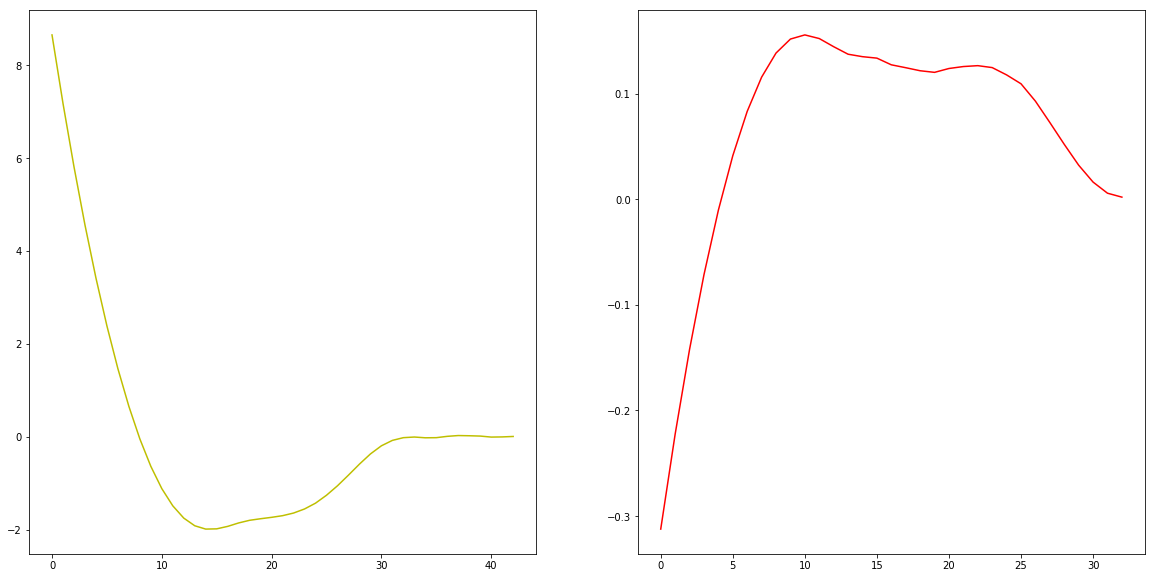

In [47]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
# plt.plot(np.array(b_weight9[2:])*(6*0.1**3) , 'g')
# plt.plot(np.array(b_weight8[2:])*(6*0.1**3) , 'b')
# plt.plot(np.array(b_weight7[2:])*(6*0.1**3) , 'm')
axs[0].plot(np.array(b_all[1:1+len(pair_knots)])*(6*0.1**3) , 'y')
#axs[0].set_xlim(10,)
#axs[0].set_ylim(-1.0,-.5)

axs[1].plot(np.array(b_all[1+len(pair_knots):])*(6*0.1**3) , 'r')

# plt.ylim(-2,10)
# plt.hlines(0, 0, 42)
# plt.legend()


# rr = np.linspace(1.3, 5.65, 436)

# plt.plot(rr, [make_bspline(b_all[1:1+len(pair_knots)], p_knot, r) for r in rr])
# plt.xlim(1.3,)
# plt.ylim(-1.5,0.2)
# plt.xlim(rr[0], rr[-1])
# plt.hlines(0.0, rr[0], rr[-1])

In [48]:
bounds

[[0, 200],
 [200, 346],
 [346, 472],
 [472, 708],
 [708, 841],
 [841, 977],
 [977, 1176],
 [1176, 1267],
 [1267, 1389],
 [1389, 1390],
 [1390, 1395],
 [1395, 1407],
 [1407, 1413]]

[-1094.023, -1094.406, -1094.26, -1094.041, -1093.69, -1093.418, -1093.274, -1093.211, -1093.221, -1093.399, -1093.5, -1093.631, -1093.791, -1093.785, -1093.723, -1093.643, -1093.48, -1093.467, -1093.349, -1093.184, -1093.123, -1093.276, -1093.355, -1093.538, -1093.709, -1093.848, -1093.781, -1093.509, -1092.896, -1092.357, -1092.172, -1092.412, -1092.996, -1093.691, -1094.331, -1095.0, -1095.324, -1095.443, -1095.486, -1095.411, -1095.067, -1094.276, -1093.34, -1092.656, -1092.314, -1092.393, -1092.788, -1093.553, -1094.313, -1095.134, -1095.779, -1096.216, -1096.334, -1096.279, -1095.935, -1095.41, -1094.697, -1093.688, -1092.637, -1091.49, -1090.526, -1089.711, -1089.045, -1088.519, -1088.344, -1088.211, -1088.306, -1088.624, -1088.858, -1088.949, -1088.921, -1088.939, -1089.004, -1089.35, -1089.591, -1089.895, -1090.463, -1090.749, -1090.82, -1090.79, -1090.59, -1090.255, -1090.033, -1089.89, -1089.855, -1089.699, -1089.53, -1089.107, -1088.628, -1088.11, -1087.731, -1087.447, -108

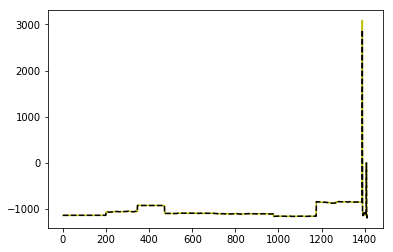

In [49]:
plt.plot(energy(X, b_all), 'y')
#plt.plot(X.dot(b_weight4), 'm')
plt.plot(y, 'k--')
# plt.xlim(len(X)-7,len(X)-1)
# plt.ylim(-1200,-1120)

#print(list(y[382:389]), list(X.dot(b_0)[382:389]))
# print([round(z, 3) for z in X.dot(b_weight9)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight8)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight7)[-6:]])


#print(bounds[index][0])
#print([round(z, 3) for z in X.dot(b_all)[-6:]])
print([round(z, 3) for z in energy(X, b_all)[bounds[3][0]:bounds[3][1]]])
print([round(z, 3) for z in y[bounds[3][0]:bounds[3][1]]])

#print([round(z, 3) for z in y[-6:]])

In [50]:
for key in targets.keys():
    targets[key]['weight'] = 1.0

In [51]:
for i, stat in enumerate(stats_list[-1:]):
    Xallx, yallx, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)
    #X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)


In [52]:
energy(Xallx, b_all)[:-6]

array([-1134.52799038, -1134.49637671, -1134.43639323, ...,
       -1095.39591165, -1085.6135675 , -1070.32835514])

In [53]:
sys.getsizeof(Xallx[1])/sys.getsizeof(Xallx[0]), sys.getsizeof(b_all)

(329, 712)

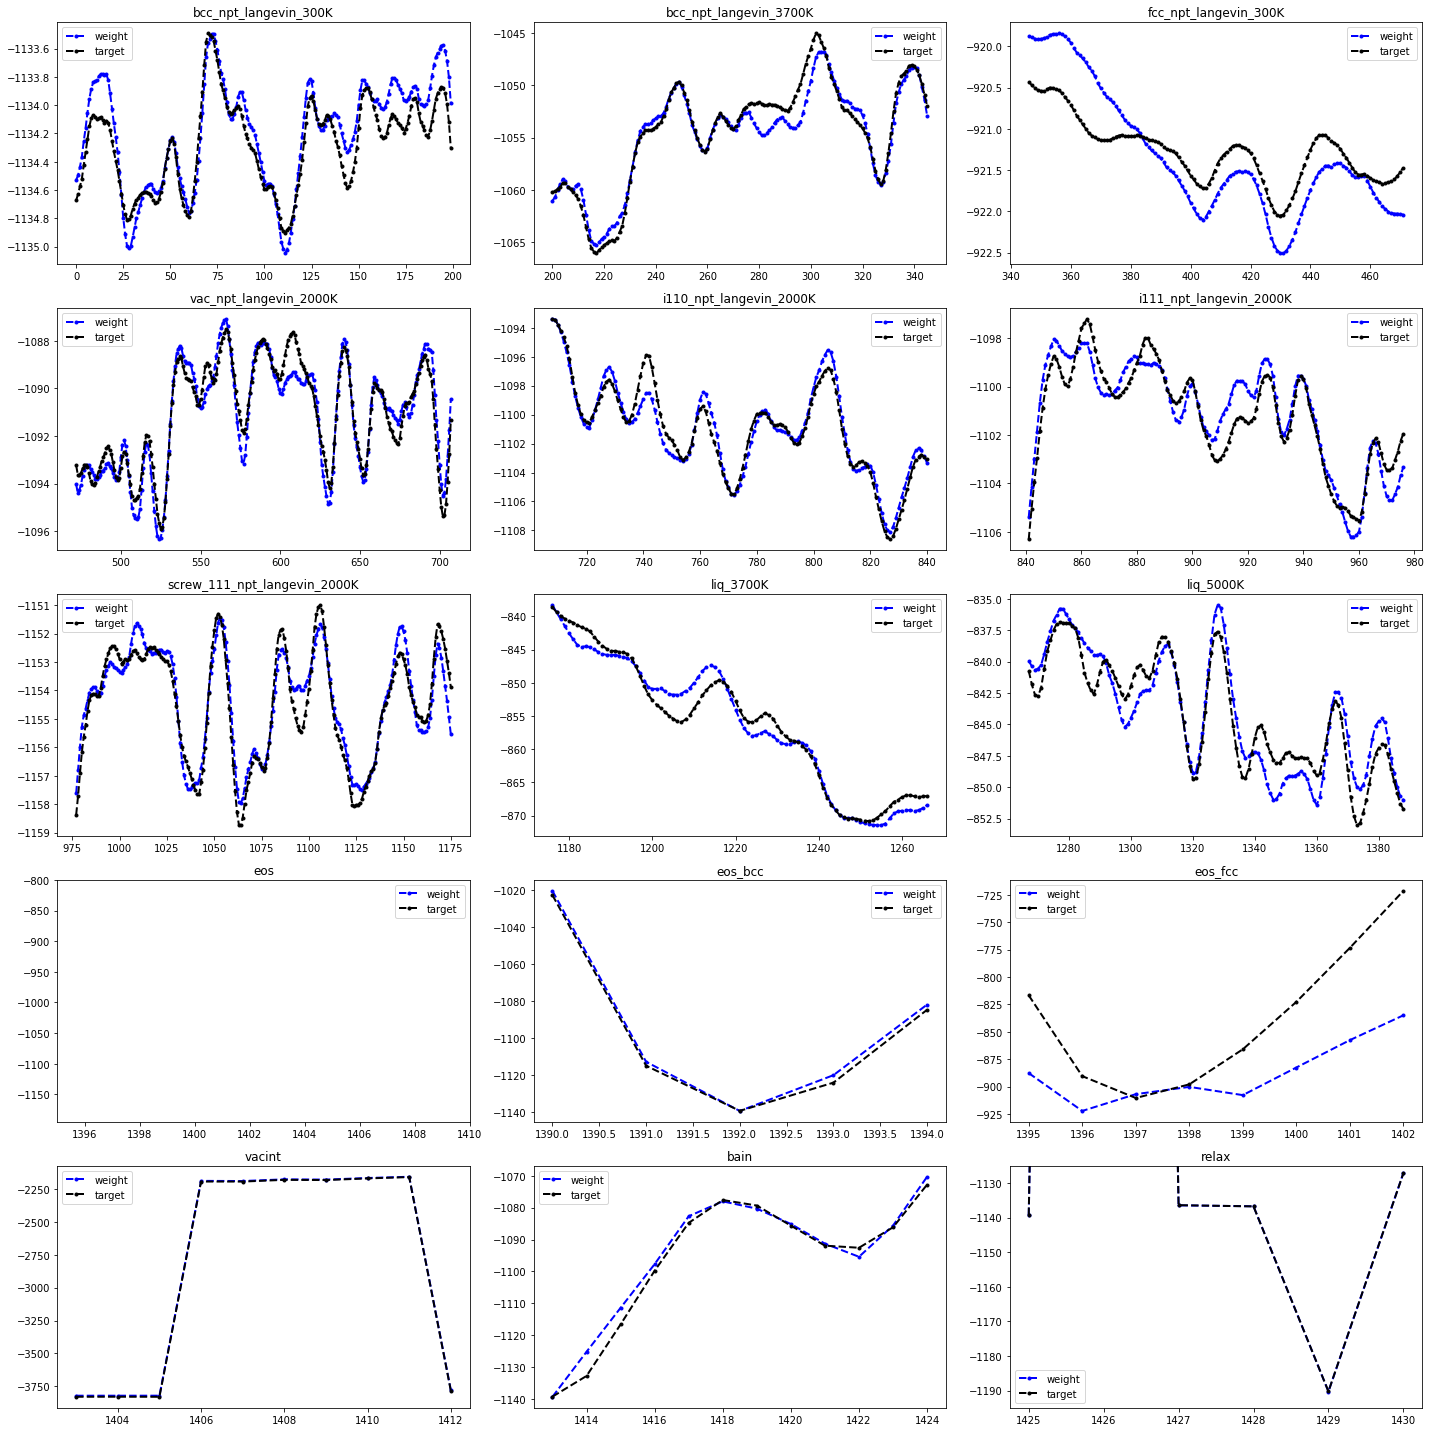

In [54]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(bounds[k][0], bounds[k][1]))

#     axes[i,j].plot(rr, Xall.dot(b_weight11)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
    axes[i,j].plot(rr, energy(Xallx,b_all)[bounds[k][0]:bounds[k][1]], 'b.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight9)[bounds[k][0]:bounds[k][1]], 'm.--', lw=2, label='weight')
    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')

    axes[i,j].plot(rr, yallx[bounds[k][0]:bounds[k][1]], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
    if trj == 'eos':
        axes[i,j].set_ylim(-1195, -800)
        axes[i,j].set_xlim(1395,1410)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [816]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi)

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

len 50


In [817]:
len(stats_tpf['relax']['energy'][0][2]), len(stats_bspline['relax']['energy'][0][2])

(50, 46)

In [818]:
for key in targets.keys():
    targets[key]['weight'] = 1.0

In [819]:
mb_knots = list(np.linspace(3.75, 5.25, 16))
pair_knots = list(np.linspace(1.05, 5.25, 43))
#pair_knots = list(np.linspace(2.05, 5.25, 33))

print(mb_knots)
print(pair_knots)

# Select knots for optimization
# cycle over knots of selected models
stats_list = []
for knot in mb_knots:
    edens_knots = [knot]
    stats = downselect(stats_bspline, pair_knots, edens_knots)
    stats_list.append(stats)

[3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [820]:
for i, stat in enumerate(stats_list[-1:]):
    Xall, yall, weights, beta, bounds = make_sd_matrices(targets, stat, keytrj=tkeys)

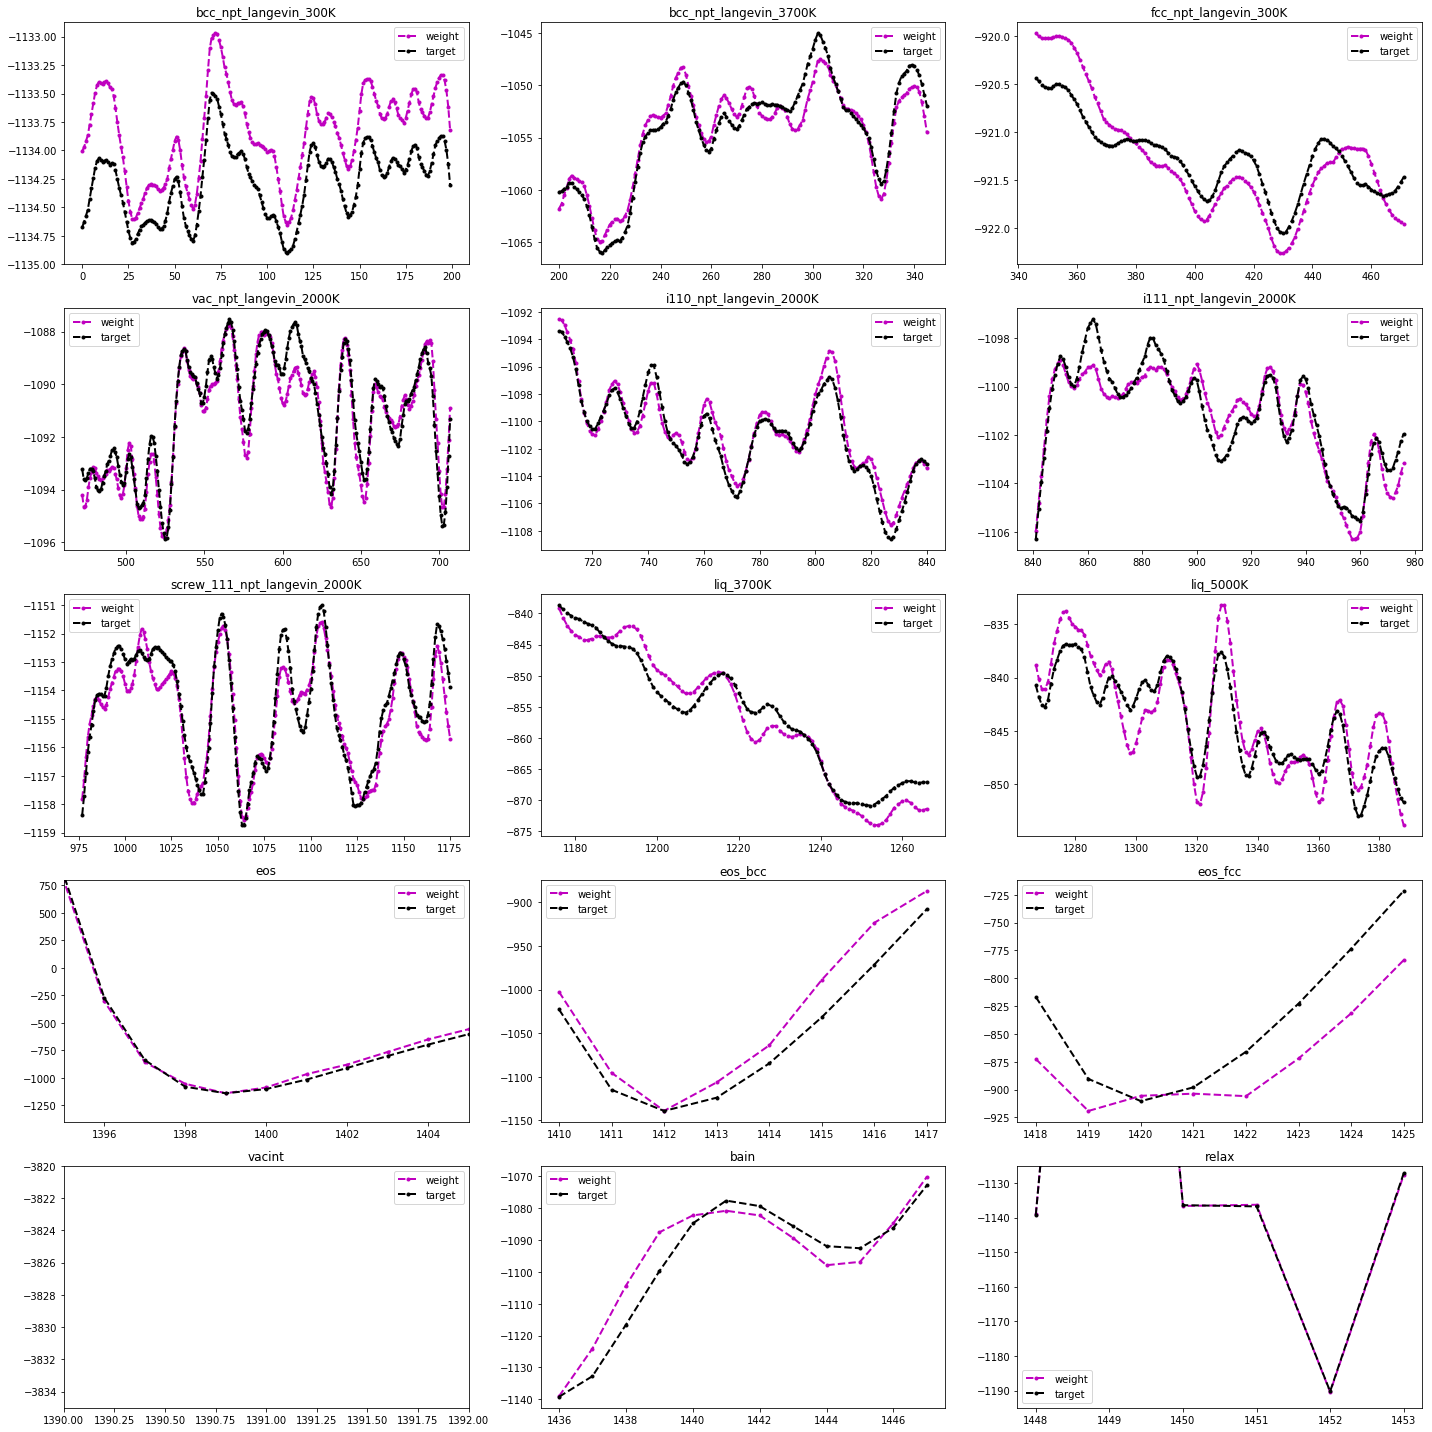

In [822]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(bounds[k][0], bounds[k][1]))

#     axes[i,j].plot(rr, Xall.dot(b_weight11)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight7)[bounds[k][0]:bounds[k][1]], 'b.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
    axes[i,j].plot(rr, Xall.dot(b_all)[bounds[k][0]:bounds[k][1]], 'm.--', lw=2, label='weight')
    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')

    axes[i,j].plot(rr, yall[bounds[k][0]:bounds[k][1]], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3820)
        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1400, 800)
        axes[i,j].set_xlim(1395,1405)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [504]:
p_knots = np.array(pair_knots)+0.4
p_knots

array([1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15, 2.25, 2.35, 2.45,
       2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15, 3.25, 3.35, 3.45, 3.55,
       3.65, 3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65,
       4.75, 4.85, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65])

In [505]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [506]:
M = _bspline_coeffs_to_tpf(43)

In [507]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[2:]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

[ 4.22824426e+03  3.54009480e+03  2.91119261e+03  2.34153772e+03
  1.83113026e+03  1.37997039e+03  9.88058321e+02  6.55394274e+02
  3.81978459e+02  1.67811053e+02  1.24862009e+01 -8.79627304e+01
 -1.43545176e+02 -1.67016514e+02 -1.68316234e+02 -1.58859588e+02
 -1.52245978e+02 -1.41522891e+02 -1.31799084e+02 -1.24427156e+02
 -1.07866113e+02 -8.29740112e+01 -6.06836589e+01 -4.81849563e+01
 -4.36744378e+01 -3.91472388e+01 -3.22134949e+01 -2.58537638e+01
 -2.26912671e+01 -2.12961404e+01 -2.06873517e+01 -1.86526528e+01
 -1.45559864e+01 -1.10689543e+01 -8.78888460e+00 -5.32464713e+00
 -1.32322585e+00  9.00599115e-01  1.19455876e+00  1.38108240e+00
 -4.40635093e-01 -1.37195754e+00 -1.22719835e+00]
[ 4.22824426e+03 -1.33728823e+04  1.41202790e+04 -4.97564098e+03
  9.10758972e-05  5.38825989e-05  3.86238098e-05  5.24520874e-06
 -2.62260437e-06 -3.64780426e-05 -4.06030059e-01 -3.56078100e+00
 -6.04279995e+00 -2.74594337e+00  2.81588787e+00 -1.47576168e+00
 -2.18415010e+00  2.05519152e+01 -1.2061

In [508]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
len(tpf_coeff), len(p_knot)

(47, 47)

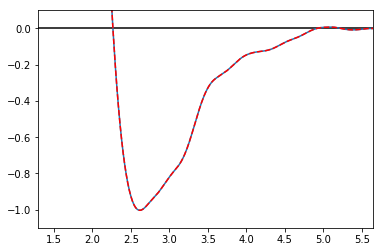

In [517]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[2:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[2:], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-1.1,0.1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [513]:
tpf_coeff

array([ 4.22824426e+03, -1.33728823e+04,  1.41202790e+04, -4.97564098e+03,
        9.10758972e-05,  5.38825989e-05,  3.86238098e-05,  5.24520874e-06,
       -2.62260437e-06, -3.64780426e-05, -4.06030059e-01, -3.56078100e+00,
       -6.04279995e+00, -2.74594337e+00,  2.81588787e+00, -1.47576168e+00,
       -2.18415010e+00,  2.05519152e+01, -1.20612704e+01,  3.75615722e+00,
        1.28935941e+01, -1.23990495e+01, -1.00747538e+01,  3.74290898e+00,
        8.99336571e+00,  6.20139912e+00, -5.61500046e+00, -5.37042186e+00,
        3.57335970e-01,  4.05308592e+00, -4.48832229e-01,  1.23121627e+00,
       -1.57619130e+00, -3.30765875e+00,  2.07427372e+00,  2.98845802e+00,
       -3.03811395e+00, -1.66779622e+00,  2.16251113e+00,  1.97469831e+00,
       -3.72323444e+00,  4.79944132e+00, -2.71294960e+00, -1.79329082e-01,
       -2.31599501e+00,  3.53683585e+00, -1.22719835e+00])

In [516]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))

print('edens') 
for c, k in zip([1.0], [5.25]):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
        
print('embed')
#print(-4.42166597e-01,  1.12818607e-04)
print(-4.49779872e-01,  1.09664665e-04)

pair
+4228.2442627d0*(1.05d0 - r)**3*H(1.05d0 - r)
-13372.8822546d0*(1.15d0 - r)**3*H(1.15d0 - r)
+14120.2789984d0*(1.25d0 - r)**3*H(1.25d0 - r)
-4975.64097977d0*(1.35d0 - r)**3*H(1.35d0 - r)
+9.10758972168e-05d0*(1.45d0 - r)**3*H(1.45d0 - r)
+5.3882598877e-05d0*(1.55d0 - r)**3*H(1.55d0 - r)
+3.86238098145e-05d0*(1.65d0 - r)**3*H(1.65d0 - r)
+5.24520874023e-06d0*(1.75d0 - r)**3*H(1.75d0 - r)
-2.62260437012e-06d0*(1.85d0 - r)**3*H(1.85d0 - r)
-3.64780426025e-05d0*(1.95d0 - r)**3*H(1.95d0 - r)
-0.406030058861d0*(2.05d0 - r)**3*H(2.05d0 - r)
-3.56078100204d0*(2.15d0 - r)**3*H(2.15d0 - r)
-6.04279994965d0*(2.25d0 - r)**3*H(2.25d0 - r)
-2.74594336748d0*(2.35d0 - r)**3*H(2.35d0 - r)
+2.8158878684d0*(2.45d0 - r)**3*H(2.45d0 - r)
-1.4757616818d0*(2.55d0 - r)**3*H(2.55d0 - r)
-2.18415009975d0*(2.65d0 - r)**3*H(2.65d0 - r)
+20.5519151688d0*(2.75d0 - r)**3*H(2.75d0 - r)
-12.061270386d0*(2.85d0 - r)**3*H(2.85d0 - r)
+3.75615721941d0*(2.95d0 - r)**3*H(2.95d0 - r)
+12.893594116d0*(3.05d0 - r)**3*H(3

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']

Parameters given to Yuri:

Embedding:
-4.42166597e-01,  1.12818607e-04,
Pair potential coefficients: Knots ending at 5.65 with steps of 0.1 A:

4.51698420e+03,  3.75910139e+03, 3.06924350e+03,  2.44738802e+03,  1.89346739e+03,  1.40738478e+03,
9.89029865e+02,  6.38294633e+02,  3.55089127e+02,  1.39357269e+02,
       -9.60824592e+00, -9.86104306e+01, -1.44135463e+02, -1.65813774e+02,
       -1.73239670e+02, -1.65893890e+02, -1.60198554e+02, -1.46418160e+02,
       -1.35762684e+02, -1.25923736e+02, -1.10532902e+02, -8.90260796e+01,
       -6.86880677e+01, -5.45283774e+01, -4.52604866e+01, -3.77851927e+01,
       -3.19692325e+01, -2.76892221e+01, -2.45864649e+01, -2.09702658e+01,
       -1.96949536e+01, -2.16298673e+01, -1.49970585e+01, -9.26360379e+00,
       -1.22233430e+01, -5.85168131e+00,  1.60207091e+00,  3.86904582e+00,
       -2.36332511e+00,  2.69685169e+00, -1.92552950e+00, -5.24093457e-01,
        1.38798423e-01